# Predicting Bike count in Munich (Project Chapter 9 Tabular Modelling Deep Dive)

To get some pratical experience I chose my own project to practice the concepts introduced in Chapter 9 "Tabular Modelling Deep Dive" of the fastai_v2 course. I wanted to share my approach and would be happy if you could point me to errors, misunderstandings or possible improvements.

1. [Goal](#introduction)
2. [Data](#data)
    1. [Get data](#getdata)
    1. [Explore data](#exploredata)
3. [Modelling](#model)
    1. [Random Forest](#rf)
    2. [Neuronal Net](#nn)    
4. [Conclusion and open questions](#conclusion)

## 1. My Goal <a name="introduction"></a>

The city of munich counts the number of bikers on six counting stations throughout munich. They provide those numbers to the public in their open data portal.

Based on this data, can I create a model that predicts the number of bikers for a given day?

## 2. The data <a name="data"></a>

At the momente there are 6 permanent bike counting stations in munich. They count bikes with sensors build into the street. The data can be accessed via the open data portal api. e.g. all currently available datasets can be retrieved with this call: https://www.opengov-muenchen.de/api/3/action/package_search?q=Raddauerz%C3%A4hlstellen&rows=1000

In April 2020 the counting station Kreuther changed. The sensor size approximatly doubled in size. Take this into account for data after 1. april.

More information:

* OpenDataPortal Munich Website (german): https://www.opengov-muenchen.de/dataset?tags=Raddauerz%C3%A4hlstellen
* Info about bike counting stations (Raddauerz√§hlstellen) (german): https://www.opengov-muenchen.de/pages/raddauerzaehlstellen
* API Doku: https://docs.ckan.org/en/ckan-2.5.3/api/
* Analysis of data 2017 & 2018 in german - [‚ÄûAufs Radl ‚Äì Fertig? ‚Äì Los!‚Äú Ergebnisse der Raddauerz√§hlstellen in M√ºnchen 2017 und 2018 (PDF)](https://www.muenchen.de/rathaus/dam/jcr:9a65625e-952f-470f-b6a1-d4270f4526cb/mb190304.pdf)


### 2.1 Get data <a name="getdata"></a>

In [24]:
import requests
import os
import itertools

In [25]:
r = requests.get('https://www.opengov-muenchen.de/api/3/action/package_search?q=Raddauerz%C3%A4hlstellen&rows=1000')
json = r.json()

In [26]:
#json

In [27]:
def download_csv(url):
    filename = 'data/' + url.rsplit('/',1)[1]
    if os.path.exists(filename):
        print(f'{filename} already exists')
    else:
        r = requests.get(url)
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        with open(filename, 'wb') as f:
            f.write(r.content)
        print(f'{filename} downloaded.')

In [28]:
resources = [[{'name':res['name'], 'url':res['url']} for res in result['resources'] if res['name'] != 'Raddauerz√§hlstellen in M√ºnchen'] for result in json['result']['results']]
resources = list(itertools.chain.from_iterable(resources))

In [29]:
for res in resources:
    download_csv(res['url'])

data/rad20170615min.csv already exists
data/rad201706tage.csv already exists
data/rad20201015min.csv already exists
data/rad202010tage.csv already exists
data/rad20200915min.csv already exists
data/rad202009tage.csv already exists
data/rad20200815min.csv already exists
data/rad202008tage.csv already exists
data/rad20200715min.csv already exists
data/rad202007tage.csv already exists
data/rad20200615min.csv already exists
data/rad202006tage.csv already exists
data/rad20200115min.csv already exists
data/rad202001tage.csv already exists
data/rad20200315min.csv already exists
data/rad202003tage.csv already exists
data/rad20200215min.csv already exists
data/rad202002tage.csv already exists
data/rad20190415min.csv already exists
data/rad201904tage.csv already exists
data/rad20181115min.csv already exists
data/rad201811tage.csv already exists
data/rad20170715min.csv already exists
data/rad201707tage.csv already exists
data/rad20170115min.csv already exists
data/rad201701tage.csv already exists

### 2.2. Explore data

In [30]:
# pip install pandas

In [31]:
import pandas as pd

In [32]:
files = [f for f in os.listdir('data') if os.path.isfile(os.path.join('data', f))]
files.sort()

#### Data complete?
For each month there should be two csv files (15 min und day). Therefore there should 92 files `(3 years * 12 month + 10 (10 for october)) * 2`

In [33]:
len(files) == (3 * 12 + 10) * 2

True

#### How does the data look like?

In [34]:
df_min15 = pd.read_csv('data/rad20201015min.csv')
df_min15

datum uhrzeit_start uhrzeit_ende zaehlstelle  richtung_1  \
0      2020.10.01         00:00        00:15      Arnulf           2   
1      2020.10.01         00:15        00:30      Arnulf           1   
2      2020.10.01         00:30        00:45      Arnulf           0   
3      2020.10.01         00:45        01:00      Arnulf           0   
4      2020.10.01         01:00        01:15      Arnulf           1   
...           ...           ...          ...         ...         ...   
17851  2020.10.31         22:45        23:00     Erhardt           5   
17852  2020.10.31         23:00        23:15     Erhardt           8   
17853  2020.10.31         23:15        23:30     Erhardt           5   
17854  2020.10.31         23:30        23:45     Erhardt           5   
17855  2020.10.31         23:45        00:00     Erhardt           5   

       richtung_2  gesamt  
0               0       2  
1               0       1  
2               0       0  
3               0       0  
4               0       1  
...           ...     ...  
17851          14      19  
17852          11      19  
17853           9      14  
17854           9      14  
17855           8      13  

[17856 rows x 7 columns]

In [35]:
df_day = pd.read_csv('data/rad202010tage.csv')
df_day

datum uhrzeit_start  uhrzeit_ende zaehlstelle  richtung_1  \
0    2020.10.01         00:00         23.59      Arnulf        1738   
1    2020.10.02         00:00         23.59      Arnulf        1469   
2    2020.10.03         00:00         23.59      Arnulf         548   
3    2020.10.04         00:00         23.59      Arnulf         821   
4    2020.10.05         00:00         23.59      Arnulf        1048   
..          ...           ...           ...         ...         ...   
181  2020.10.27         00:00         23.59     Erhardt        2289   
182  2020.10.28         00:00         23.59     Erhardt        2675   
183  2020.10.29         00:00         23.59     Erhardt        1334   
184  2020.10.30         00:00         23.59     Erhardt        2167   
185  2020.10.31         00:00         23.59     Erhardt        2780   

     richtung_2  gesamt  min-temp  max-temp  niederschlag  bewoelkung  \
0           107    1845       6.5      19.4           0.0          65   
1            89    1558       9.8      18.4           0.0          99   
2            37     585       5.1      22.1           2.9          75   
3            37     858       4.7      17.3           0.7          73   
4            63    1111       9.0      14.6           4.7          98   
..          ...     ...       ...       ...           ...         ...   
181        2213    4502       3.9      11.1           0.0          75   
182        2592    5267       3.5      14.7           2.4          95   
183        1342    2676       8.9      11.2          15.5          94   
184        2142    4309       9.0      14.7           0.0          99   
185        2621    5401       6.3      17.9           0.0          55   

     sonnenstunden  
0              8.2  
1              0.9  
2              2.9  
3              6.5  
4              1.8  
..             ...  
181            1.5  
182            1.3  
183            0.0  
184            0.6  
185            8.9  

[186 rows x 12 columns]

* Every file contains all counting_stations (zaehlstelle).
* The counts are in three value direction_1 (richtung_1), direction_2 (richtung_2) and total (gesamt)
* The day datasets also contain weather information - min/max temp, sun hours, rain and cloud

In [36]:
# Available counting stations (zaehlstellen):
df_day.zaehlstelle.unique()

array(['Arnulf', 'Kreuther', 'Olympia', 'Hirsch', 'Margareten', 'Erhardt'],
      dtype=object)

In [37]:
# getDataframe of datafiles
# - prefixes - filter used files by prefix e.g. rad2018 for year 2018
# - zaehlstelle - filter by given counting station ()
def getDataframe(prefixes, zaehlstelle: str):
    files = [f for f in os.listdir('data') if os.path.isfile(os.path.join('data', f)) and f.endswith('tage.csv')]
    files = [f for f in files if f.startswith(prefixes)]
    df = pd.concat([pd.read_csv(os.path.join('data', f)) for f in files])
    return df[df.zaehlstelle == zaehlstelle].sort_values(by=['datum'])

In [38]:
df_arnulf = getDataframe(zaehlstelle='Arnulf', prefixes = ('rad2017', 'rad2018', 'rad2019'))

In [39]:
df_arnulf

datum uhrzeit_start uhrzeit_ende zaehlstelle  richtung_1  richtung_2  \
0   2017.01.01      00:00:00        23.59      Arnulf         121          14   
1   2017.01.02      00:00:00        23.59      Arnulf         362          38   
2   2017.01.03      00:00:00        23.59      Arnulf         232          30   
3   2017.01.04      00:00:00        23.59      Arnulf         182          25   
4   2017.01.05      00:00:00        23.59      Arnulf         193          31   
..         ...           ...          ...         ...         ...         ...   
26  2019.12.27         00:00        23.59      Arnulf         312          30   
27  2019.12.28         00:00        23.59      Arnulf         337          37   
28  2019.12.29         00:00        23.59      Arnulf         253          32   
29  2019.12.30         00:00        23.59      Arnulf         550          52   
30  2019.12.31         00:00        23.59      Arnulf         329          34   

    gesamt  min-temp  max-temp  niederschlag  bewoelkung  sonnenstunden  
0      135      -6.1       2.6           0.0          36            5.9  
1      400      -5.4       0.8           3.2          69            0.3  
2      262      -2.1       0.6           0.0          85            3.6  
3      207      -0.9       1.3           2.2          94            0.0  
4      224      -7.1      -0.2           0.0          88            0.0  
..     ...       ...       ...           ...         ...            ...  
26     342       1.7       4.9           4.9          98            0.0  
27     374      -2.1       2.0           0.0          69            3.2  
28     285      -4.8       2.5           0.0          26            7.9  
29     602      -4.4       6.0           0.0           9            8.0  
30     363      -0.5       8.6           0.0          60            6.8  

[1034 rows x 12 columns]

#### Are there missing days?

In [40]:
from datetime import date, timedelta, datetime

def findMissingDays(df):
    dates = df.datum.map(lambda x: datetime.strptime(x, '%Y.%m.%d')).tolist()
    dates.sort()
    d = set(dates[0] + timedelta(x) for x in range((dates[-1] - dates[0]).days))
    return sorted(d - set(dates))

In [41]:
missing = findMissingDays(df_arnulf)
len(missing), missing[0], missing[-1]

(61, Timestamp('2019-06-01 00:00:00'), Timestamp('2019-07-31 00:00:00'))

There are missing days from June to July 2019

#### Plot counts for a month

In [42]:
# pip install matplotlib

In [43]:
import matplotlib.pyplot as plt
import numpy as np

In [44]:
plt.rcParams['figure.figsize'] = [20, 15]

df = getDataframe(prefixes=('rad2018'), zaehlstelle='Arnulf')

<ipython-input-45-f5cfea7d9034>:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.axes()


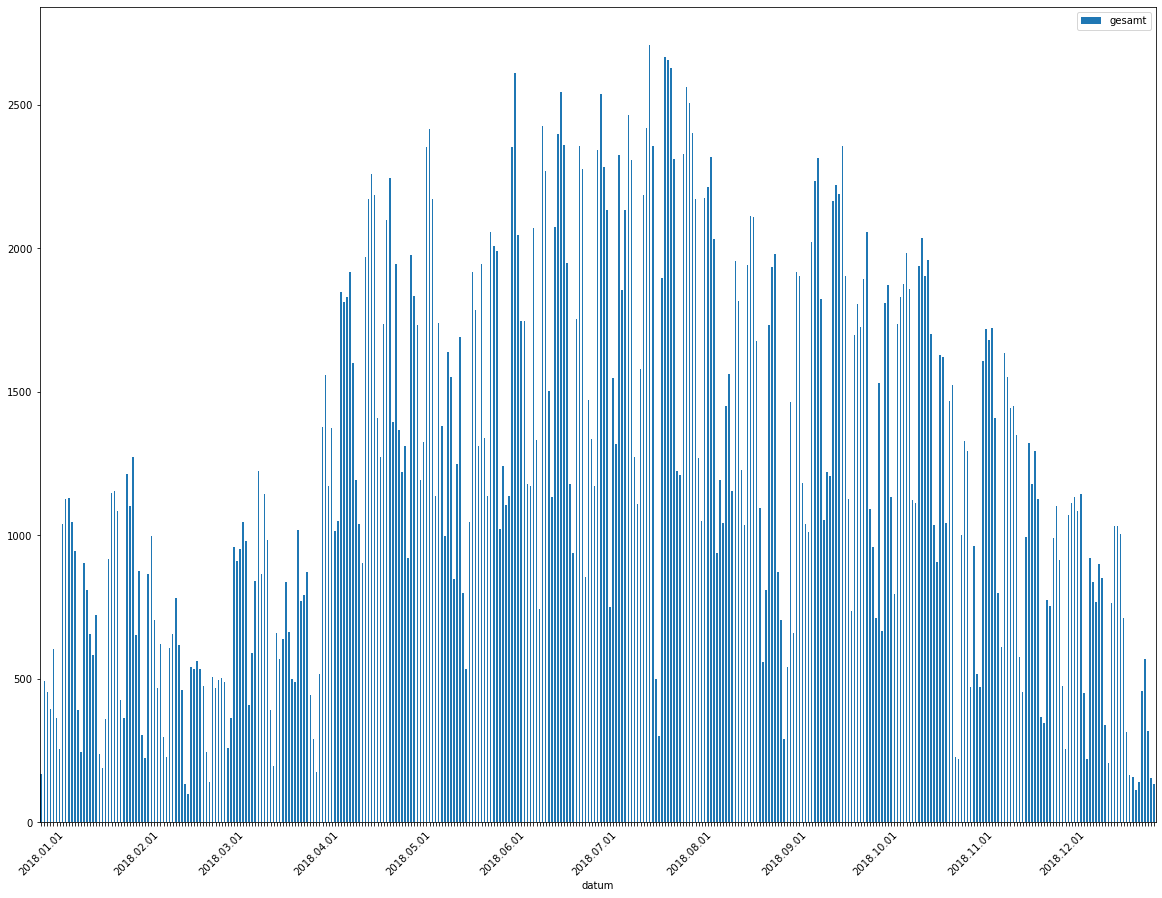

In [45]:
df.plot.bar(x='datum', y='gesamt', rot=45)
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
for index, label in enumerate(x_axis.get_ticklabels()):
    if not label.get_text().endswith('01'):
        label.set_visible(False)
plt.show()
plt.close()

## 3. Modelling <a name="model"></a>

I will work with the daily numbers because they already contain the weather information.
I will use the year 2017 & 2018 as training data and 2019 for validation.

### 3.1. Random Forest <a name="rf"></a>

#### Prepare data

In [46]:
# conda install -c fastai -c pytorch fastai

In [47]:
from fastai.tabular.all import *

/opt/conda/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [48]:
df = getDataframe(prefixes=('rad2017', 'rad2018', 'rad2019'), zaehlstelle='Arnulf')
# add date columns like day of week etc. 
df = add_datepart(df, 'datum')
df.head()

uhrzeit_start uhrzeit_ende  datumWeek zaehlstelle  richtung_1  richtung_2  \
0      00:00:00        23.59         52      Arnulf         121          14   
1      00:00:00        23.59          1      Arnulf         362          38   
2      00:00:00        23.59          1      Arnulf         232          30   
3      00:00:00        23.59          1      Arnulf         182          25   
4      00:00:00        23.59          1      Arnulf         193          31   

   gesamt  min-temp  max-temp  niederschlag  ...  datumDay  datumDayofweek  \
0     135      -6.1       2.6           0.0  ...         1               6   
1     400      -5.4       0.8           3.2  ...         2               0   
2     262      -2.1       0.6           0.0  ...         3               1   
3     207      -0.9       1.3           2.2  ...         4               2   
4     224      -7.1      -0.2           0.0  ...         5               3   

   datumDayofyear  datumIs_month_end  datumIs_month_start  \
0               1              False                 True   
1               2              False                False   
2               3              False                False   
3               4              False                False   
4               5              False                False   

   datumIs_quarter_end  datumIs_quarter_start  datumIs_year_end  \
0                False                   True             False   
1                False                  False             False   
2                False                  False             False   
3                False                  False             False   
4                False                  False             False   

   datumIs_year_start  datumElapsed  
0                True    1483228800  
1               False    1483315200  
2               False    1483401600  
3               False    1483488000  
4               False    1483574400  

[5 rows x 24 columns]

In [49]:
# drop richtung columns because the are sum up to gesamt value, which we want to predict
df = df.drop(['richtung_1', 'richtung_2'], axis=1)

In [50]:
# Create Tabular Pandas
procs = [Categorify, FillMissing] # processings or transformations
cond = (df.datumYear<2019)
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

dep_var = 'gesamt' # dependent variable, the number we want to predict

cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [51]:
to.show(3)

In [52]:
# save
save_pickle((URLs.path()/'../to.pkl'), to)

#### Train Random Forest

In [53]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [54]:
xs,y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [55]:
def rf(xs, y, n_estimators=40, max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, max_features=max_features, oob_score=True).fit(xs,y)

In [56]:
# root mean square error - penalizes large differences. Would MAE be better as metric?
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [57]:
m = rf(xs, y)

In [58]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(153.160631, 286.214093)

In [59]:
mean_absolute_error(m.predict(xs), y),mean_absolute_error(m.predict(valid_xs), valid_y)

(108.4387433911589, 216.78431321076258)

In [60]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
r_mse(preds.mean(0), valid_y)

286.214093

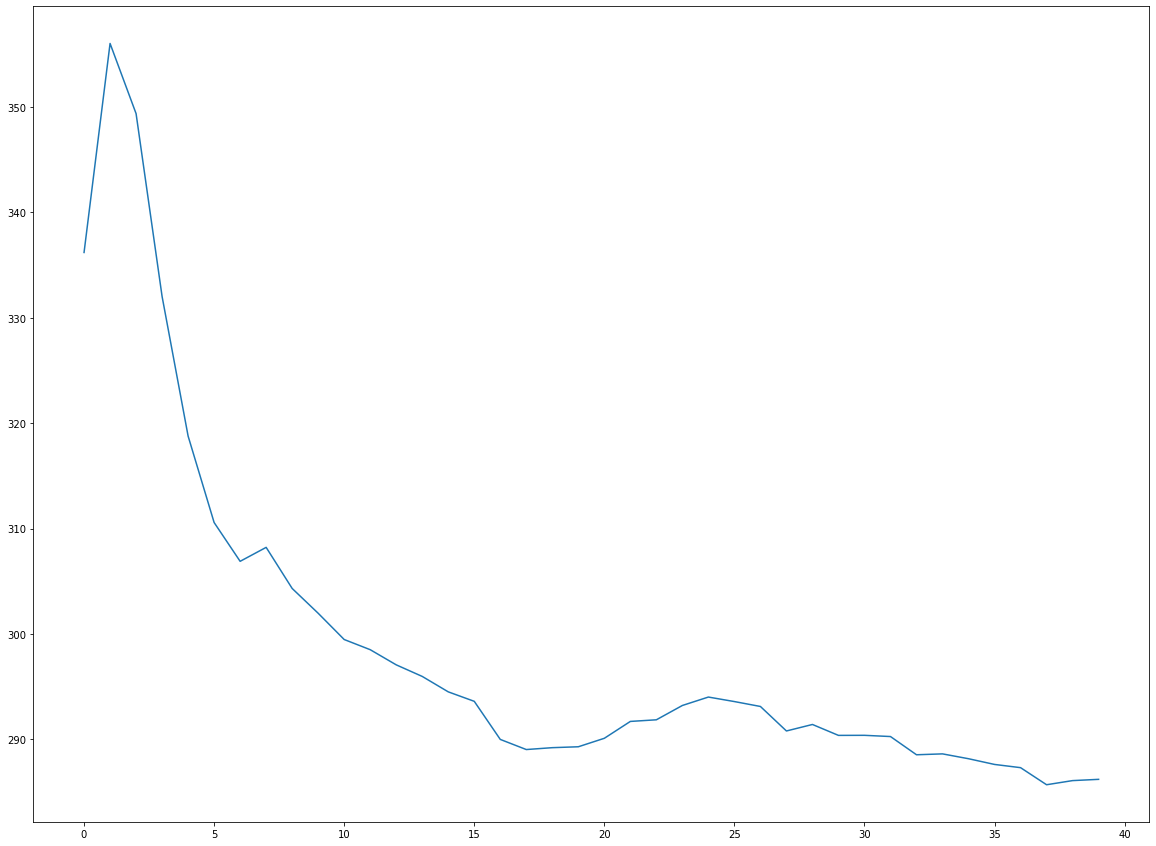

In [61]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

üò≥ Question: Best result in a previous run seem to be arround 20 not 40 what does that mean?

#### Out of bag error
Good metric to check why our predictions in our training set or better then in our validation set. 108.36805410446944 vs 212.6982400192359

In [62]:
r_mse(m.oob_prediction_, y)

220.634446

üò≥ Our error in the training set is higher than in the validation set. The example in the fastai book p.302 has an example where the error is lower.

What does this indicate?

#### Prediction confidence

how confident can I be in those predictions? One way is to look at the variance between the trees in the forest. Smaller is better.

In [63]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
print(preds.shape) # 40 trees, with 304 predictions for each day
preds_std = preds.std(0) # standard deviation
preds_std[:20]

(40, 304)


array([213.54205311, 243.18868107, 274.17708928, 213.26384998,
        72.26651621, 104.25023534, 202.87261006, 187.26733866,
       159.31380009, 218.36638653, 224.49423358,  74.52510082,
       109.01137248, 190.75751523, 250.09481755, 312.84911248,
       233.3505351 , 265.5347628 ,  89.40963798,  88.10693646])

#### Feature importance

Which feature are most important?

In [64]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)
fi = rf_feat_importance(m, xs)
fi[:10]

cols       imp
12        max-temp  0.337019
19  datumDayofweek  0.211616
11        min-temp  0.172952
15   sonnenstunden  0.127771
20  datumDayofyear  0.037821
14      bewoelkung  0.031079
2        datumWeek  0.026360
13    niederschlag  0.023729
10    datumElapsed  0.017092
18        datumDay  0.008336

Most important features are max-temp followed by day of week. Seems reasonable to me. e.g. workdays vs weekdays and cold days vs warm days.

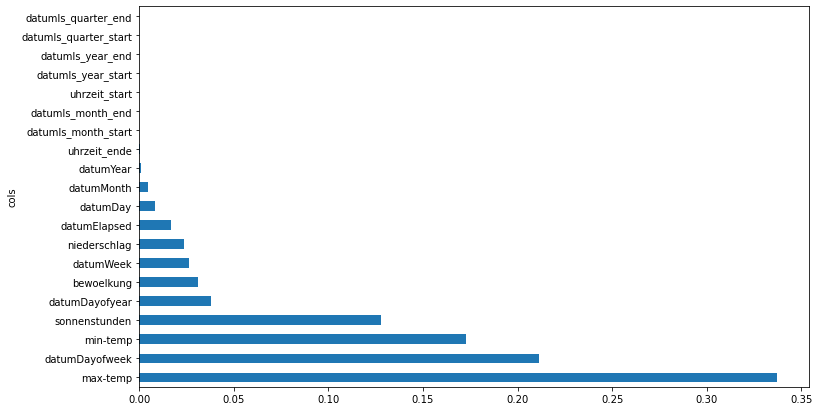

In [65]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:20]);

#### Remove unimportant features

In [66]:
to_keep =fi[fi.imp > 0.005].cols
len(to_keep)

10

In [67]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [68]:
m = rf(xs_imp, y)
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(157.047798, 287.071143)

üò≥ Got worse in comparison to prev run: 151.42499, 285.167373. But the removed columns shouldn't be important e.g. uhrzeit_start/end is always the same.

#### Redundant features

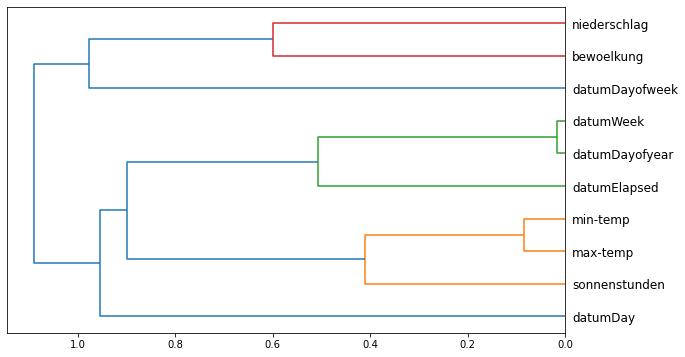

In [69]:
from scipy.cluster import hierarchy as hc

def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()
    
cluster_columns(xs_imp)

In [70]:
xs_imp.head()

max-temp  datumDayofweek  min-temp  sonnenstunden  datumDayofyear  \
0       2.6               6      -6.1            5.9               1   
1       0.8               0      -5.4            0.3               2   
2       0.6               1      -2.1            3.6               3   
3       1.3               2      -0.9            0.0               4   
4      -0.2               3      -7.1            0.0               5   

   bewoelkung  datumWeek  niederschlag  datumElapsed  datumDay  
0          36         52           0.0             1         1  
1          69          1           3.2             2         2  
2          85          1           0.0             3         3  
3          94          1           2.2             4         4  
4          88          1           0.0             5         5

month and day of year are close, makes sense both indicate the "season" or the progress into the year.
Will keep it for now.

#### Waterfall Chart

In [71]:
#!pip install treeinterpreter
#!pip install waterfallcharts

In [72]:
from treeinterpreter import treeinterpreter
row = valid_xs_imp.iloc[:1]
prediction,bias,contributions = treeinterpreter.predict(m, row.values)
prediction[0], bias[0], contributions[0].sum()

/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


(array([671.90960664]), 1166.9882191780823, -495.07861253472555)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

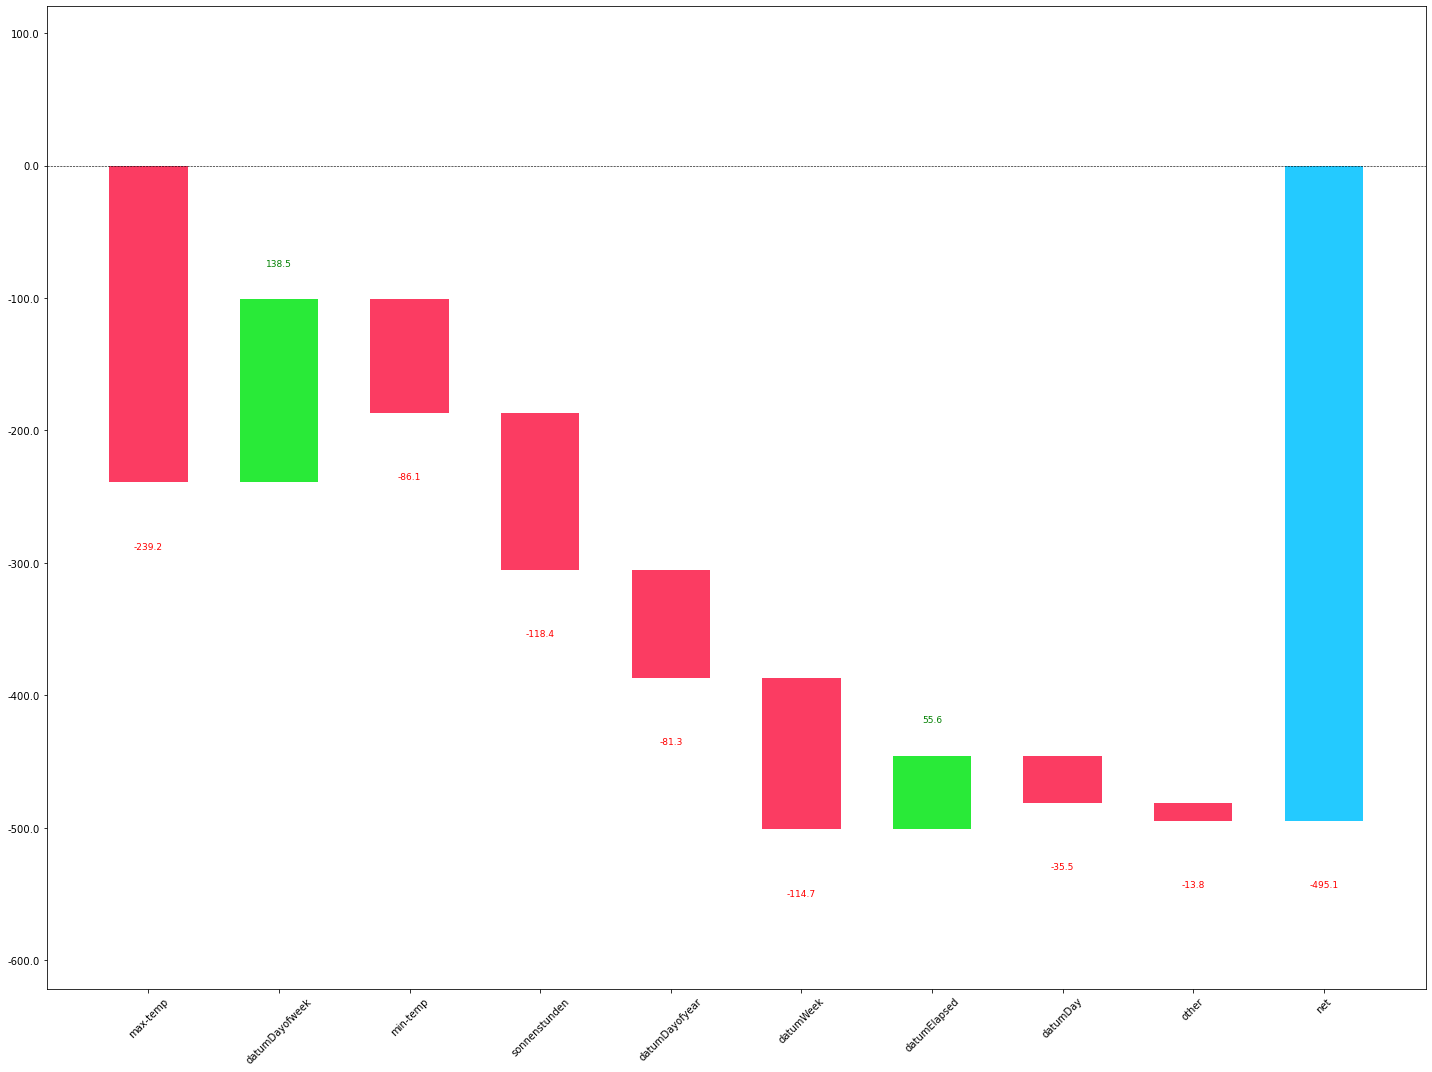

In [73]:
import waterfall_chart
waterfall_chart.plot(valid_xs_imp.columns, contributions[0], threshold=0.08, rotation_value=45)

Indicates the importance of different features for the prediction.

#### Out of domain data

In [74]:
df_dom = pd.concat([xs_imp, valid_xs_imp])
is_valid = np.array([0]*len(xs_imp) + [1]*len(valid_xs_imp))

In [75]:
# RandomForest to decide if value is in train oder valid set.
m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

cols       imp
8    datumElapsed  0.948344
2        min-temp  0.015860
0        max-temp  0.013591
4  datumDayofyear  0.005913
6       datumWeek  0.004799
5      bewoelkung  0.004126

By extracting the most important features which seperate train from validation set we find feature which we could drop.

In [76]:
xs_final = xs_imp.drop('datumElapsed', axis=1)
valid_xs_final = valid_xs_imp.drop('datumElapsed', axis=1)
m = rf(xs_final, y)
print(f'without out of dom: {m_rmse(m, valid_xs_final, valid_y)}')

without out of dom: 287.871411


üò≥ Got worse again.

### Summary of RandomForest

In [77]:
m = rf(xs, y)
print(f'orig: {m_rmse(m, valid_xs, valid_y)}')
m = rf(xs_imp, y)
print(f'imp: {m_rmse(m, valid_xs_imp, valid_y)}')
m = rf(xs_imp.drop('datumElapsed',axis=1), y)
print(f'without out of dom: {m_rmse(m, valid_xs_imp.drop("datumElapsed",axis=1), valid_y)}')

orig: 291.173572
imp: 289.024892
without out of dom: 290.190423


#### less trees

In [78]:
m = rf(xs, y, 25)
print(f'orig: {m_rmse(m, valid_xs, valid_y)}')
m = rf(xs_imp, y, 25)
print(f'imp: {m_rmse(m, valid_xs_imp, valid_y)}')
m = rf(xs_imp.drop('datumElapsed',axis=1), y, 25)
print(f'without out of dom: {m_rmse(m, valid_xs_imp.drop("datumElapsed",axis=1), valid_y)}')

orig: 284.252772
imp: 287.217749
without out of dom: 293.213637


#### Open questions

üò≥ Results change on every rerun. Therfore: How comparable are the results with the different changes then? 

Should I fix a seed for the RandomForest, is this possible?

### 3.1. Neural Net <a name="nn"></a>

Let's try it with a neural net

In [79]:
df_nn = getDataframe(zaehlstelle='Arnulf', prefixes = ('rad2017', 'rad2018', 'rad2019'))
df_nn = add_datepart(df_nn, 'datum')
df_nn = df_nn[list(xs_final.columns) + [dep_var]]
df_nn

max-temp  datumDayofweek  min-temp  sonnenstunden  datumDayofyear  \
0        2.6               6      -6.1            5.9               1   
1        0.8               0      -5.4            0.3               2   
2        0.6               1      -2.1            3.6               3   
3        1.3               2      -0.9            0.0               4   
4       -0.2               3      -7.1            0.0               5   
..       ...             ...       ...            ...             ...   
26       4.9               4       1.7            0.0             361   
27       2.0               5      -2.1            3.2             362   
28       2.5               6      -4.8            7.9             363   
29       6.0               0      -4.4            8.0             364   
30       8.6               1      -0.5            6.8             365   

    bewoelkung  datumWeek  niederschlag  datumDay  gesamt  
0           36         52           0.0         1     135  
1           69          1           3.2         2     400  
2           85          1           0.0         3     262  
3           94          1           2.2         4     207  
4           88          1           0.0         5     224  
..         ...        ...           ...       ...     ...  
26          98         52           4.9        27     342  
27          69         52           0.0        28     374  
28          26         52           0.0        29     285  
29           9          1           0.0        30     602  
30          60          1           0.0        31     363  

[1034 rows x 10 columns]

In [80]:
cont_nn, cat_nn = cont_cat_split(df_nn, max_card=9000, dep_var=dep_var)

In [81]:
cont_nn, cat_nn

(['max-temp', 'min-temp', 'sonnenstunden', 'niederschlag'],
 ['datumDayofweek', 'datumDayofyear', 'bewoelkung', 'datumWeek', 'datumDay'])

In [82]:
df_nn[cat_nn].nunique()

datumDayofweek      7
datumDayofyear    365
bewoelkung         81
datumWeek          52
datumDay           31
dtype: int64

In [83]:
df_nn=df_nn.astype('float')

procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn, procs_nn, cat_nn, cont_nn, splits=splits, y_names=dep_var)

In [84]:
dls = to_nn.dataloaders()
y = to_nn.train.y
y.min(), y.max()

(29.0, 2707.0)

In [85]:
learn = tabular_learner(dls, y_range=(29,2707), layers=[500,250], n_out=1, loss_func=F.mse_loss)

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.0005754399462603033)

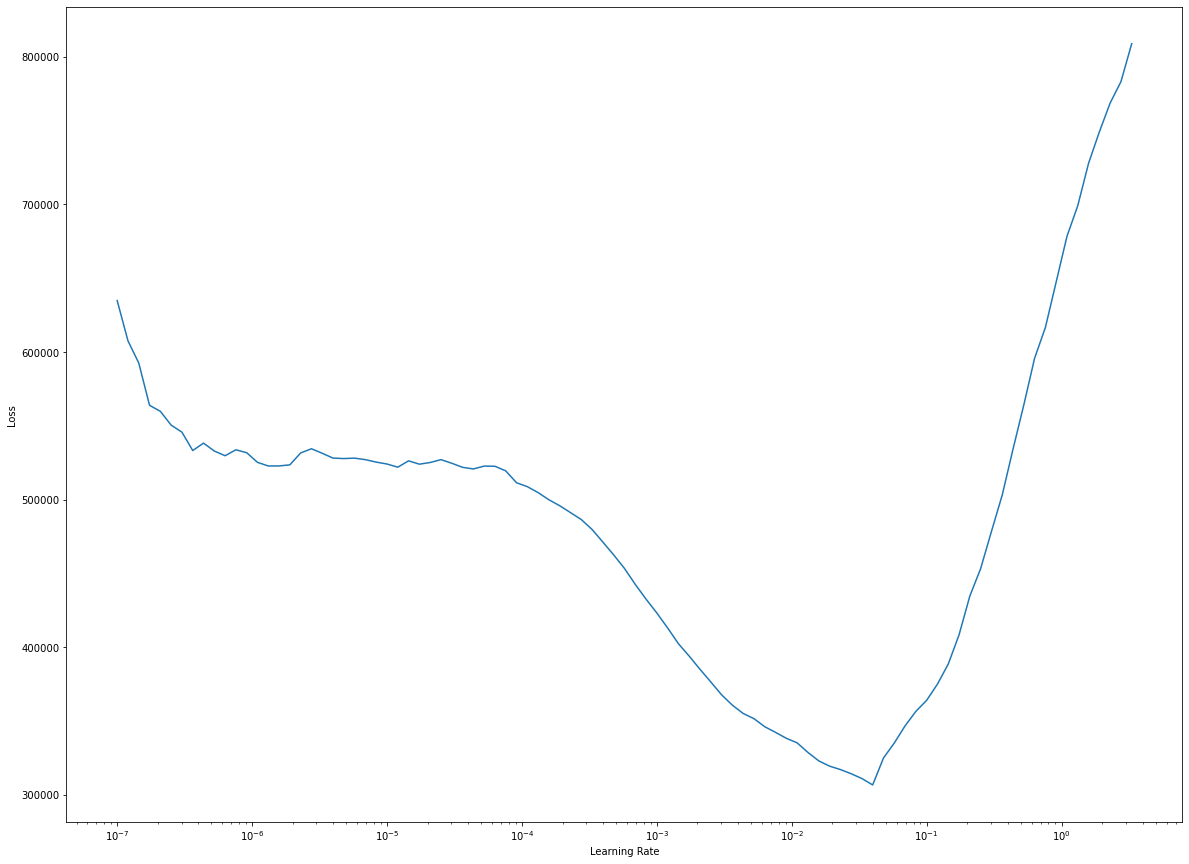

In [86]:
learn.lr_find()

In [87]:
learn.fit_one_cycle(20, 1e-2)

In [88]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

287.241378

Is better than the random forest

## 4. Conclusion <a name="conclusion"></a>

### Are these models helpful?

I tried two approaches RandomForest and a Neuronal Net and both seem to work in general, but I still have no real feeling if the models are helpful and what the RSME (RootMeanSquaredError) means for the quality of my model in general. Are those good models that would be helpful?

Should I use another metric?
Are there other metrics besided RSME (RootSquareMeanError) that would make it easier for me to grasp the performance of my model? Should I maybe use a relative metric? e.g. a percentage Metric? or would MeanAbsoluteError help me?
The OOB score is relative from 0 (bad) to 1 (good). It was arround 0.88. Does that mean it is an okay model?

Or does the real value of the predictions only gets visible when I would have a real use case in which they are used? e.g. is an value 100 below the real value helpful for traffic planners?

### RandomForest

* Results change on every rerun. Therfore: How comparable are the results with the different changes then? Should I fix a seed for the RandomForest, is this possible?
* What does it mean if the predictions get worse with more trees?


### Future Steps

* I really like the waterfall chart for the RandomForest which shows which influence different features have. Is there something similiar for a neural net? e.g. like the visualisation of CNN Layers for image classification
* Add bavarian holidays to the data
* Use not only one counting station but the total of all six
* Use datasets where weekdays and weekends are seperated. Could I train a "Should I bike or take the bus?"-Model on this?
 

### Use different Metrics

In [89]:
rf_m = rf(xs_final, y)
rf_preds = rf_m.predict(valid_xs_final)

nn_preds, nn_y = learn.get_preds()

In [90]:
#### Root Mean Squared Error (RMSE)
print(r_mse(rf_preds, valid_y))
print(r_mse(nn_preds, nn_y))

287.184818
287.241378


In [91]:
from fastai import metrics

#### Root Mean Squared Error (RMSE)

In [92]:
# Root Mean Squared Error (RMSE)
print(r_mse(rf_preds, valid_y))
print(r_mse(nn_preds, nn_y))

287.184818
287.241378


#### Mean absolute error (MAE)

In [93]:
# Mean absolute error (MAE)
def mae(preds, y): return np.abs(preds - y).mean()

print(mae(rf_preds, valid_y))
print(mae(nn_preds, nn_y))

218.98469129480472
tensor(213.8722)


#### Mean absolute percentage error (MAPE)

In [94]:
# Mean absolute percentage error (MAPE)
def mape(preds, y): return np.abs((preds - y)/preds).mean()

print(mape(rf_preds, valid_y))
print(mape(nn_preds, nn_y))

0.24876636569604726
tensor(0.2506)


#### normalized Mean Absolute Error / nMAE

In [95]:
def nmae(preds, y): return np.abs((preds - y)).mean() / np.abs(preds).mean()

print(nmae(rf_preds, valid_y))
print(nmae(nn_preds, nn_y))

0.21333076948448737
tensor(0.2058)


# Part 2 Improvements

## Better visualize results in plots

In [96]:
valid_xs.iloc[0].datumYear, valid_xs.iloc[0].datumMonth, valid_xs.iloc[0].datumDay

(2019.0, 1.0, 1.0)

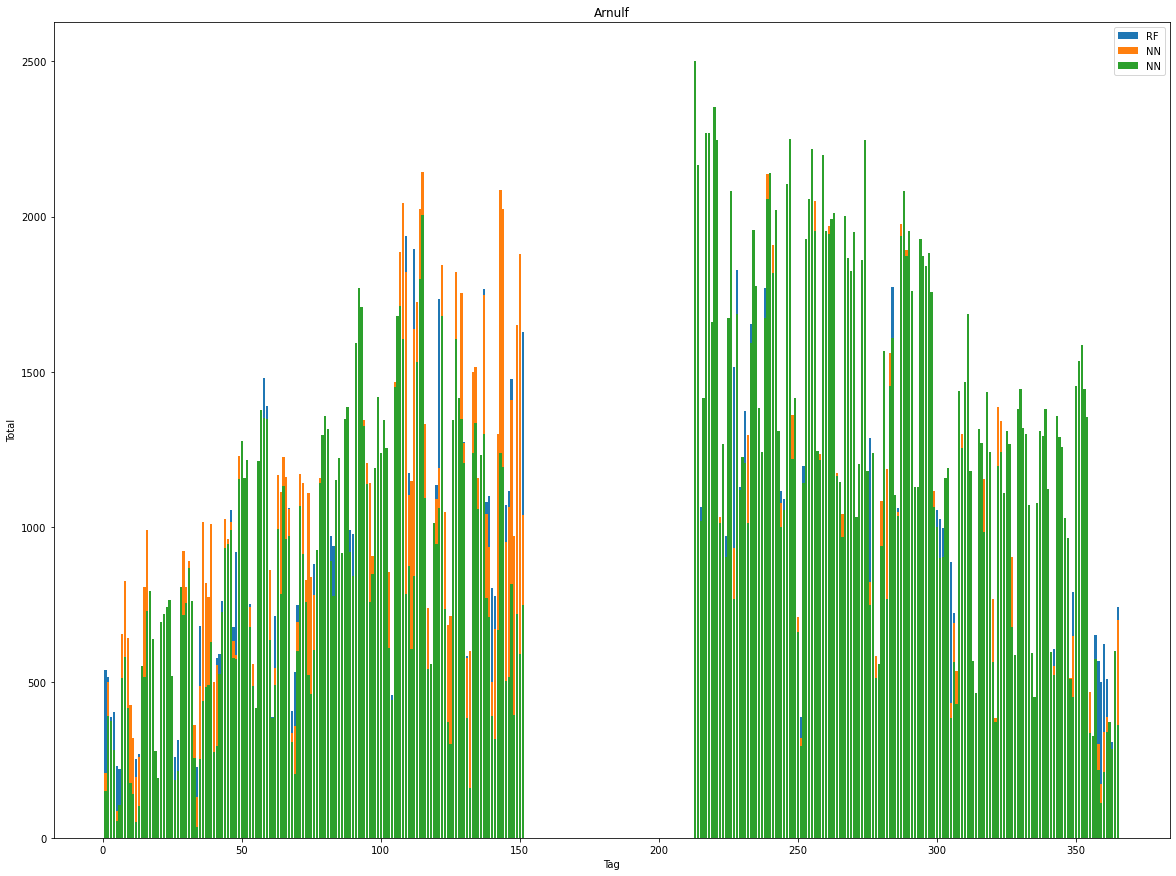

In [97]:
plt.bar(valid_xs['datumDayofyear'], rf_preds, label='RF')
plt.bar(valid_xs['datumDayofyear'], nn_preds, label='NN')
plt.bar(valid_xs['datumDayofyear'], valid_y, label='NN')
plt.xlabel('Tag')
plt.ylabel('Total')
plt.title("Arnulf")
plt.legend()

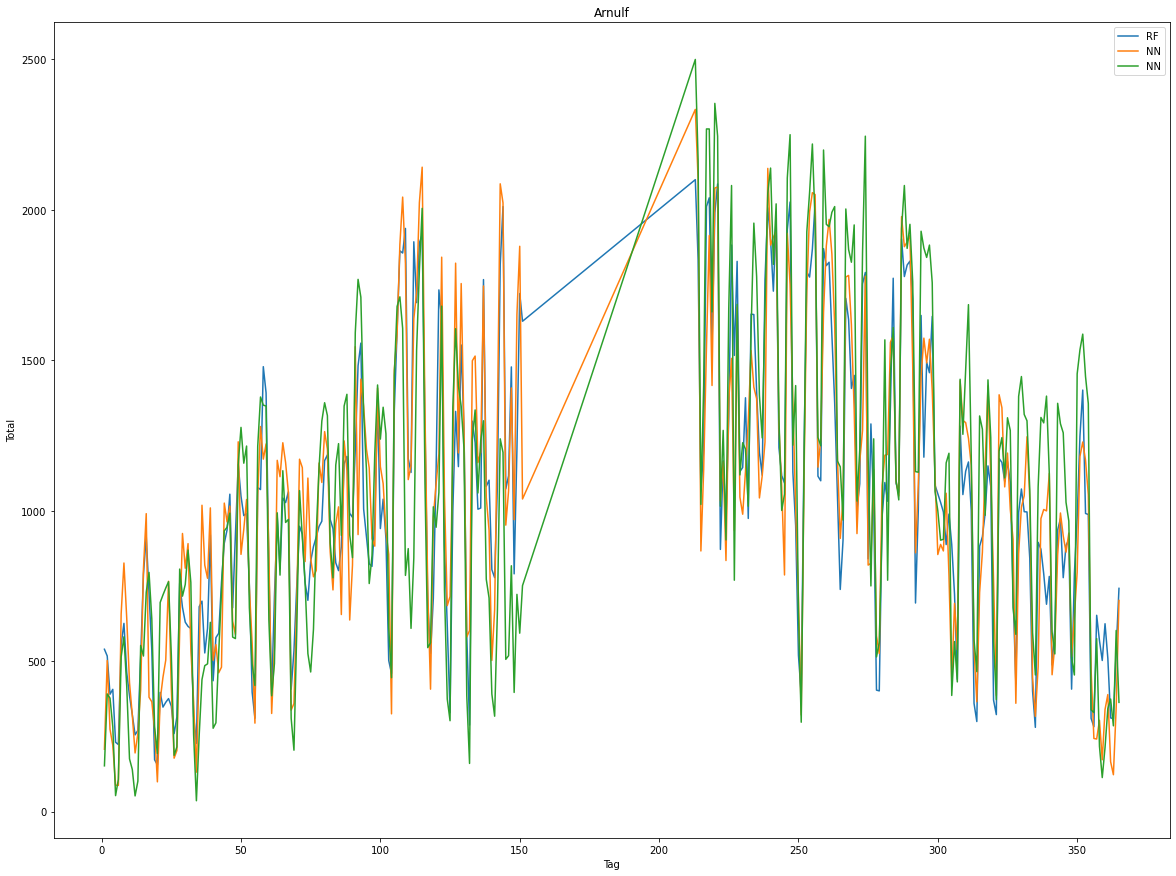

In [98]:
s = 0
n = 365
plt.plot(valid_xs['datumDayofyear'][s:n], rf_preds[s:n], label='RF')
plt.plot(valid_xs['datumDayofyear'][s:n], nn_preds[s:n], label='NN')
plt.plot(valid_xs['datumDayofyear'][s:n], valid_y[s:n], label='NN')
plt.xlabel('Tag')
plt.ylabel('Total')
plt.title("Arnulf")
plt.legend()

In [99]:
valid_xs_final.iloc[90:100]

max-temp  datumDayofweek  min-temp  sonnenstunden  datumDayofyear  \
0  15.900000               0       5.3           11.3              91   
1  21.299999               1       3.9            9.2              92   
2  20.900000               2       4.8            6.5              93   
3  12.200000               3       2.9            5.8              94   
4   9.300000               4       3.3            1.0              95   
5  16.799999               5       5.2            8.4              96   
6  16.500000               6       5.0            9.1              97   
7  11.500000               0       8.2            0.0              98   
8  16.600000               1       8.5            3.2              99   
9  12.000000               2       8.0            0.0             100   

   bewoelkung  datumWeek  niederschlag  datumDay  
0          21         14           0.0         1  
1          95         14           0.0         2  
2          84         14           0.0         3  
3          84         14           0.0         4  
4          79         14           0.0         5  
5          79         14           0.0         6  
6          79         14           0.0         7  
7          99         15           0.9         8  
8          95         15           0.0         9  
9          96         15           1.1        10

In [100]:
len(valid_y.loc[lambda valid_y: valid_y < 200]), len(y.loc[lambda y: y < 200])

(12, 35)

In [101]:
df_2018 = getDataframe(prefixes=('rad2018'), zaehlstelle='Arnulf')
df_2018 = add_datepart(df_2018, 'datum')

In [102]:
df_2017 = getDataframe(prefixes=('rad2017'), zaehlstelle='Arnulf')
df_2017 = add_datepart(df_2017, 'datum')

In [103]:
df_2020 = getDataframe(prefixes=('rad2020'), zaehlstelle='Arnulf')
df_2020 = add_datepart(df_2020, 'datum')

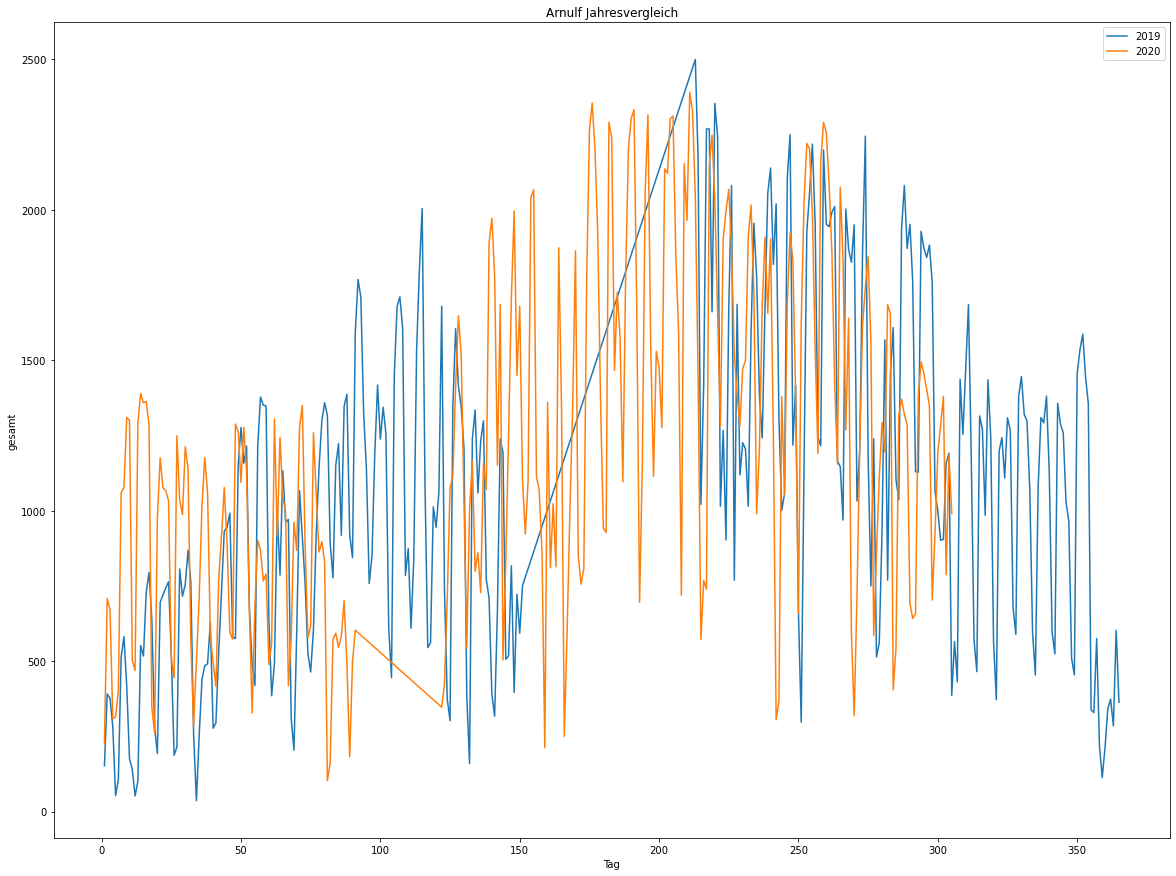

In [104]:
s = 0
n = 304
#plt.plot(valid_xs['datumDayofyear'][s:n], rf_preds[s:n], label='RF')
#plt.plot(valid_xs['datumDayofyear'][s:n], nn_preds[s:n], label='NN')
#plt.plot(df_2017['datumDayofyear'][s:n], df_2017['gesamt'][s:n], label='2017')
#plt.plot(df_2018['datumDayofyear'][s:n], df_2018['gesamt'][s:n], label='2018')
plt.plot(valid_xs['datumDayofyear'][s:n], valid_y[s:n], label='2019')
plt.plot(df_2020['datumDayofyear'][s:n], df_2020['gesamt'][s:n], label='2020')
plt.xlabel('Tag')
plt.ylabel('gesamt')
plt.title("Arnulf Jahresvergleich")
plt.legend()

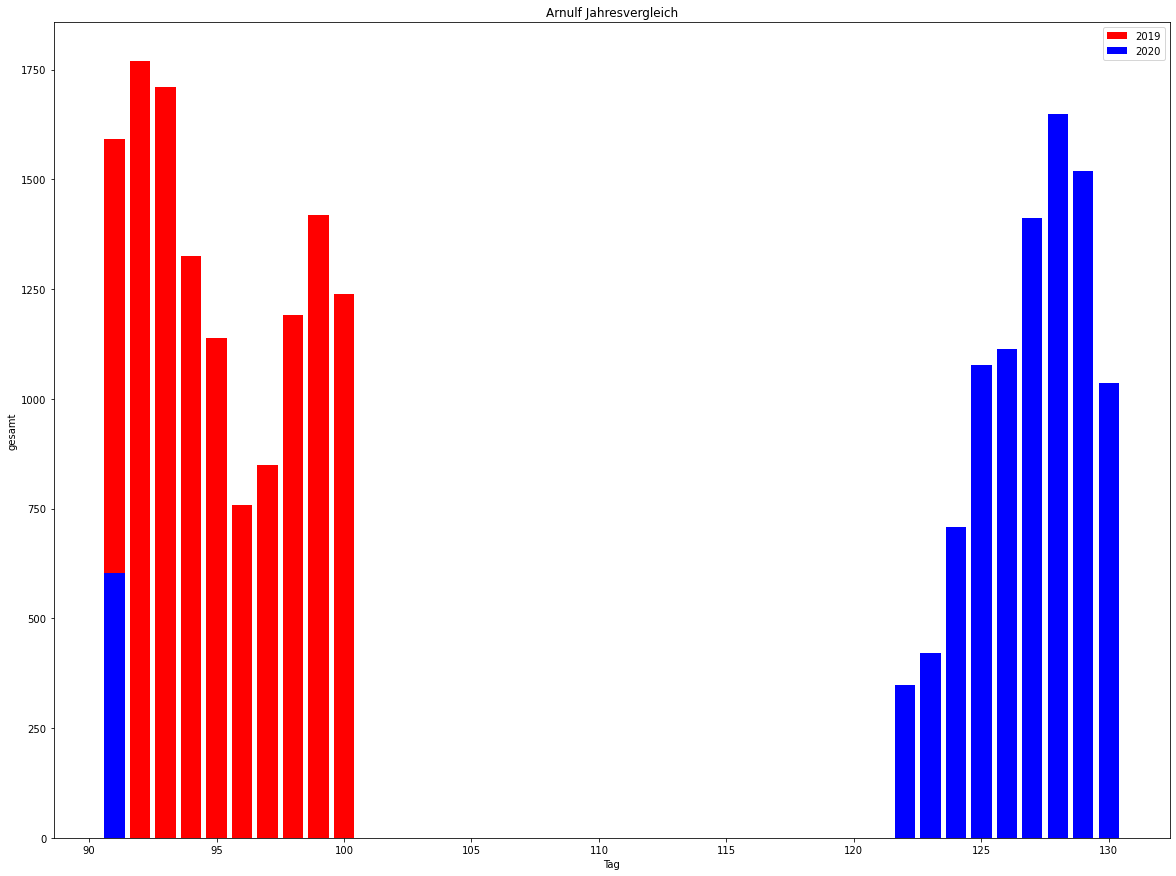

In [105]:
import numpy.ma as ma

s = 90
n = 100

y1 = valid_y[s:n].to_numpy()
y2 = df_2020['gesamt'][s:n].to_numpy()

x1 = valid_xs['datumDayofyear'][s:n].to_numpy()
x2 = df_2020['datumDayofyear'][s:n].to_numpy()

mask1 = ma.where(y1>=y2)
mask2 = ma.where(y2>=y1)

plt.bar(x1[mask1], y1[mask1], color='r', label='2019')
plt.bar(x2, y2, color='b', label='2020')
plt.bar(x1[mask2], y1[mask2], color='r')
plt.xlabel('Tag')
plt.ylabel('gesamt')
plt.title("Arnulf Jahresvergleich")
plt.legend()

In [106]:
df = getDataframe(prefixes=('rad2019'), zaehlstelle='Arnulf')

In [107]:
df

datum uhrzeit_start  uhrzeit_ende zaehlstelle  richtung_1  \
0   2019.01.01      00:00:00         23.59      Arnulf         138   
1   2019.01.02      00:00:00         23.59      Arnulf         361   
2   2019.01.03      00:00:00         23.59      Arnulf         345   
3   2019.01.04      00:00:00         23.59      Arnulf         255   
4   2019.01.05      00:00:00         23.59      Arnulf          41   
..         ...           ...           ...         ...         ...   
26  2019.12.27         00:00         23.59      Arnulf         312   
27  2019.12.28         00:00         23.59      Arnulf         337   
28  2019.12.29         00:00         23.59      Arnulf         253   
29  2019.12.30         00:00         23.59      Arnulf         550   
30  2019.12.31         00:00         23.59      Arnulf         329   

    richtung_2  gesamt  min-temp  max-temp  niederschlag  bewoelkung  \
0           14     152       2.7       5.2           1.6          99   
1           30     391      -2.1       3.2           0.6          88   
2           32     377      -3.1      -0.6           0.0          93   
3           27     282      -1.7      -0.3           5.0          96   
4           12      53      -0.9       1.0          22.1          95   
..         ...     ...       ...       ...           ...         ...   
26          30     342       1.7       4.9           4.9          98   
27          37     374      -2.1       2.0           0.0          69   
28          32     285      -4.8       2.5           0.0          26   
29          52     602      -4.4       6.0           0.0           9   
30          34     363      -0.5       8.6           0.0          60   

    sonnenstunden  
0             0.0  
1             0.7  
2             2.9  
3             0.0  
4             0.0  
..            ...  
26            0.0  
27            3.2  
28            7.9  
29            8.0  
30            6.8  

[304 rows x 12 columns]

In [108]:
def addMissingDays(df):
    df['date'] = pd.to_datetime(df['datum'], format="%Y.%m.%d")
    idx = pd.date_range(df['date'].iloc[0], df['date'].iloc[-1])
    df.index = pd.DatetimeIndex(df['date'])
    df = df.reindex(idx)
    return df

In [109]:
df = addMissingDays(df)

In [110]:
df[df.index.duplicated()]

Empty DataFrame
Columns: [datum, uhrzeit_start, uhrzeit_ende, zaehlstelle, richtung_1, richtung_2, gesamt, min-temp, max-temp, niederschlag, bewoelkung, sonnenstunden, date]
Index: []

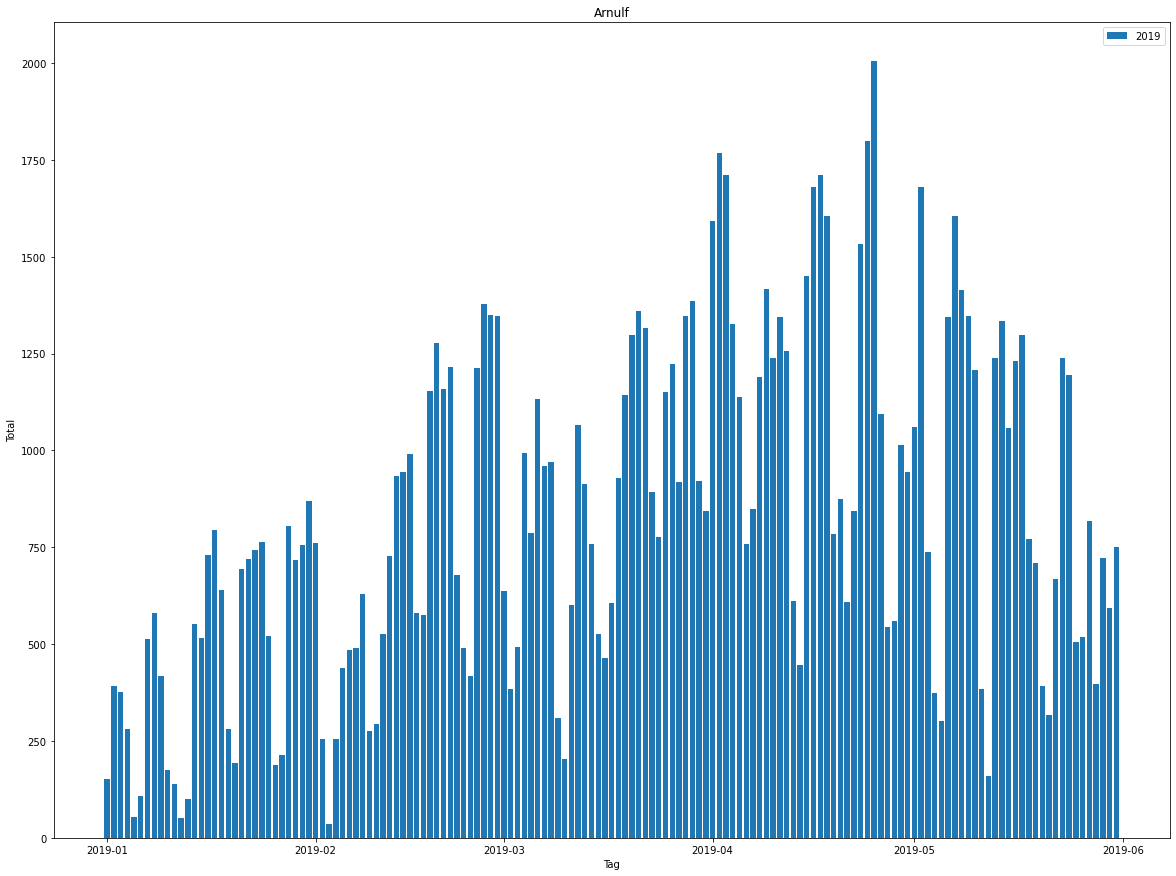

In [111]:
s = 0
n = 180
plt.bar(df['date'][s:n], df['gesamt'][s:n], label='2019')
plt.xlabel('Tag')
plt.ylabel('Total')
plt.title("Arnulf")
plt.legend()

In [112]:
pred_df = getDataframe(prefixes=('rad2019'), zaehlstelle='Arnulf')
pred_df = addMissingDays(pred_df)
#pred_df = add_datepart(pred_df, 'datum')
#pred_df = pred_df[list(xs_final.columns)]
pred_df

datum uhrzeit_start  uhrzeit_ende zaehlstelle  richtung_1  \
2019-01-01  2019.01.01      00:00:00         23.59      Arnulf       138.0   
2019-01-02  2019.01.02      00:00:00         23.59      Arnulf       361.0   
2019-01-03  2019.01.03      00:00:00         23.59      Arnulf       345.0   
2019-01-04  2019.01.04      00:00:00         23.59      Arnulf       255.0   
2019-01-05  2019.01.05      00:00:00         23.59      Arnulf        41.0   
...                ...           ...           ...         ...         ...   
2019-12-27  2019.12.27         00:00         23.59      Arnulf       312.0   
2019-12-28  2019.12.28         00:00         23.59      Arnulf       337.0   
2019-12-29  2019.12.29         00:00         23.59      Arnulf       253.0   
2019-12-30  2019.12.30         00:00         23.59      Arnulf       550.0   
2019-12-31  2019.12.31         00:00         23.59      Arnulf       329.0   

            richtung_2  gesamt  min-temp  max-temp  niederschlag  bewoelkung  \
2019-01-01        14.0   152.0       2.7       5.2           1.6        99.0   
2019-01-02        30.0   391.0      -2.1       3.2           0.6        88.0   
2019-01-03        32.0   377.0      -3.1      -0.6           0.0        93.0   
2019-01-04        27.0   282.0      -1.7      -0.3           5.0        96.0   
2019-01-05        12.0    53.0      -0.9       1.0          22.1        95.0   
...                ...     ...       ...       ...           ...         ...   
2019-12-27        30.0   342.0       1.7       4.9           4.9        98.0   
2019-12-28        37.0   374.0      -2.1       2.0           0.0        69.0   
2019-12-29        32.0   285.0      -4.8       2.5           0.0        26.0   
2019-12-30        52.0   602.0      -4.4       6.0           0.0         9.0   
2019-12-31        34.0   363.0      -0.5       8.6           0.0        60.0   

            sonnenstunden       date  
2019-01-01            0.0 2019-01-01  
2019-01-02            0.7 2019-01-02  
2019-01-03            2.9 2019-01-03  
2019-01-04            0.0 2019-01-04  
2019-01-05            0.0 2019-01-05  
...                   ...        ...  
2019-12-27            0.0 2019-12-27  
2019-12-28            3.2 2019-12-28  
2019-12-29            7.9 2019-12-29  
2019-12-30            8.0 2019-12-30  
2019-12-31            6.8 2019-12-31  

[365 rows x 13 columns]

In [113]:
def getPredsForRF(df):
    df = add_datepart(df, 'datum')
    results = pd.DataFrame(columns=['date', 'pred'])
    for index, x in df.iterrows():
        pred = -1
        if not pd.isnull(x['gesamt']):
            pred = rf_m.predict([x[list(xs_final.columns)]])[0]     
        dfTemp = pd.DataFrame(data={'date': [x['date']], 'pred': [pred]})
        results = results.append(dfTemp)
    return results

In [114]:
pred_df

datum uhrzeit_start  uhrzeit_ende zaehlstelle  richtung_1  \
2019-01-01  2019.01.01      00:00:00         23.59      Arnulf       138.0   
2019-01-02  2019.01.02      00:00:00         23.59      Arnulf       361.0   
2019-01-03  2019.01.03      00:00:00         23.59      Arnulf       345.0   
2019-01-04  2019.01.04      00:00:00         23.59      Arnulf       255.0   
2019-01-05  2019.01.05      00:00:00         23.59      Arnulf        41.0   
...                ...           ...           ...         ...         ...   
2019-12-27  2019.12.27         00:00         23.59      Arnulf       312.0   
2019-12-28  2019.12.28         00:00         23.59      Arnulf       337.0   
2019-12-29  2019.12.29         00:00         23.59      Arnulf       253.0   
2019-12-30  2019.12.30         00:00         23.59      Arnulf       550.0   
2019-12-31  2019.12.31         00:00         23.59      Arnulf       329.0   

            richtung_2  gesamt  min-temp  max-temp  niederschlag  bewoelkung  \
2019-01-01        14.0   152.0       2.7       5.2           1.6        99.0   
2019-01-02        30.0   391.0      -2.1       3.2           0.6        88.0   
2019-01-03        32.0   377.0      -3.1      -0.6           0.0        93.0   
2019-01-04        27.0   282.0      -1.7      -0.3           5.0        96.0   
2019-01-05        12.0    53.0      -0.9       1.0          22.1        95.0   
...                ...     ...       ...       ...           ...         ...   
2019-12-27        30.0   342.0       1.7       4.9           4.9        98.0   
2019-12-28        37.0   374.0      -2.1       2.0           0.0        69.0   
2019-12-29        32.0   285.0      -4.8       2.5           0.0        26.0   
2019-12-30        52.0   602.0      -4.4       6.0           0.0         9.0   
2019-12-31        34.0   363.0      -0.5       8.6           0.0        60.0   

            sonnenstunden       date  
2019-01-01            0.0 2019-01-01  
2019-01-02            0.7 2019-01-02  
2019-01-03            2.9 2019-01-03  
2019-01-04            0.0 2019-01-04  
2019-01-05            0.0 2019-01-05  
...                   ...        ...  
2019-12-27            0.0 2019-12-27  
2019-12-28            3.2 2019-12-28  
2019-12-29            7.9 2019-12-29  
2019-12-30            8.0 2019-12-30  
2019-12-31            6.8 2019-12-31  

[365 rows x 13 columns]

In [115]:
rf_2019 = getPredsForRF(pred_df)

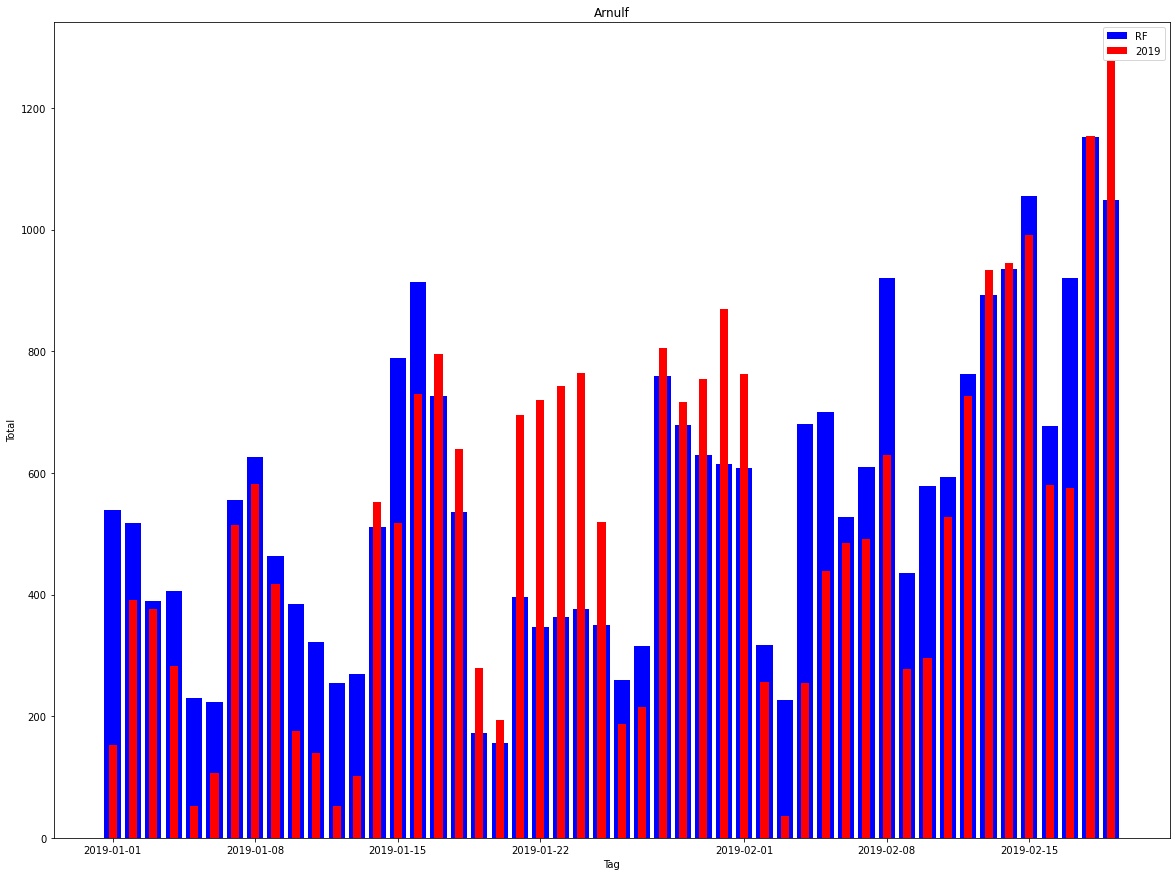

In [116]:
s = 0
n = 50
plt.bar(rf_2019['date'][s:n], rf_2019['pred'][s:n], label='RF', color='blue', width=0.8)
plt.bar(df['date'][s:n], df['gesamt'][s:n], label='2019', color='red', width=0.4)
plt.xlabel('Tag')
plt.ylabel('Total')
plt.title("Arnulf")
plt.legend()

In [117]:
def plotResults(df, preds, s=0, n=365):
    plt.bar(preds['date'][s:n], preds['pred'][s:n], label='RF', color='blue', width=0.8)
    plt.bar(df['date'][s:n], df['gesamt'][s:n], label='2019', color='red', width=0.4)
    plt.xlabel('Tag')
    plt.ylabel('Total')
    plt.title("Arnulf")
    plt.legend()

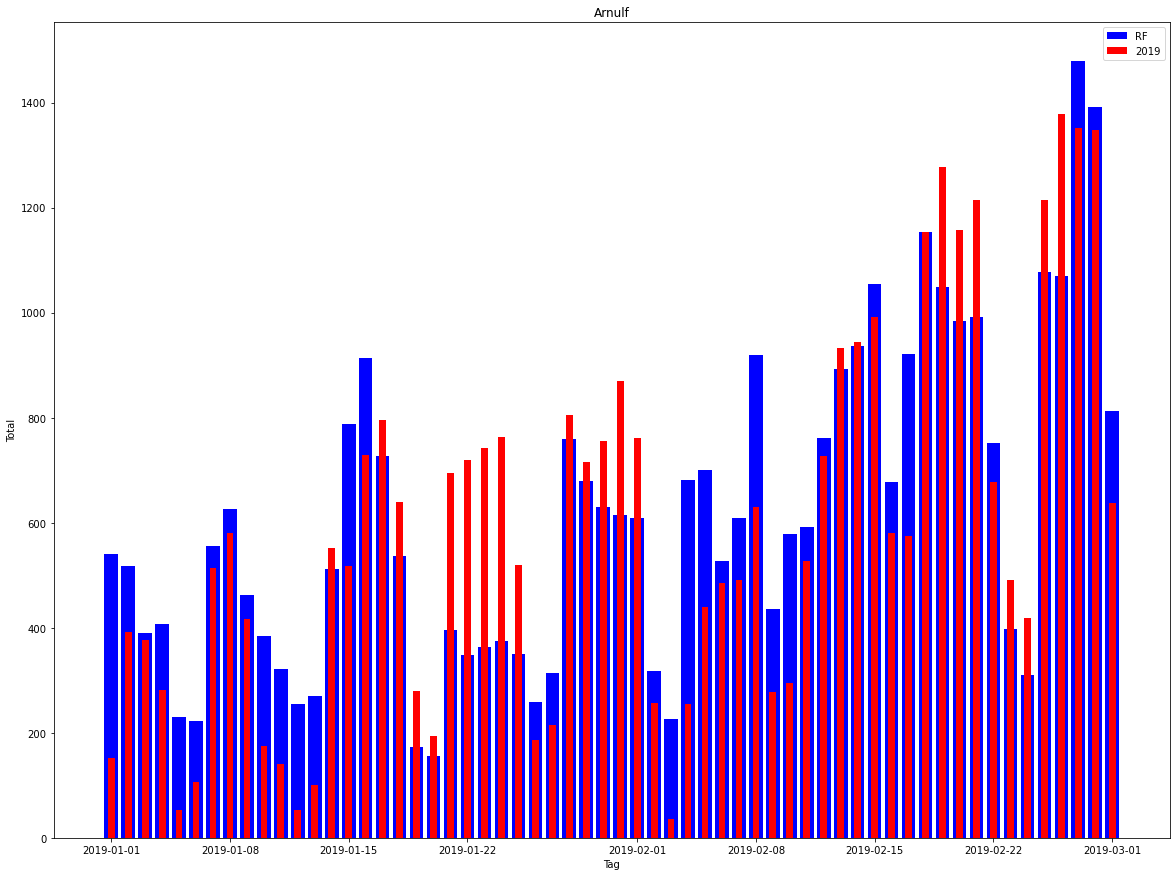

In [118]:
plotResults(df, rf_2019, n=60)

Vorhersage f√ºr 2020:

In [119]:
df2020 = getDataframe(prefixes='rad2020', zaehlstelle='Arnulf')

In [120]:
df2020 = df2020.drop('datum;uhrzeit_start;uhrzeit_ende;zaehlstelle;richtung_1;richtung_2;gesamt;min-temp;max-temp;niederschlag;bewoelkung;sonnenstunden', axis=1)

In [121]:
df2020 = addMissingDays(df2020)

In [122]:
df2020

datum uhrzeit_start  uhrzeit_ende zaehlstelle  richtung_1  \
2020-01-01  2020.01.01         00:00         23.59      Arnulf       201.0   
2020-01-02  2020.01.02         00:00         23.59      Arnulf       632.0   
2020-01-03  2020.01.03         00:00         23.59      Arnulf       626.0   
2020-01-04  2020.01.04         00:00         23.59      Arnulf       283.0   
2020-01-05  2020.01.05         00:00         23.59      Arnulf       277.0   
...                ...           ...           ...         ...         ...   
2020-10-27  2020.10.27         00:00         23.59      Arnulf      1214.0   
2020-10-28  2020.10.28         00:00         23.59      Arnulf      1305.0   
2020-10-29  2020.10.29         00:00         23.59      Arnulf       736.0   
2020-10-30  2020.10.30         00:00         23.59      Arnulf      1105.0   
2020-10-31  2020.10.31         00:00         23.59      Arnulf       961.0   

            richtung_2  gesamt  min-temp  max-temp  niederschlag  bewoelkung  \
2020-01-01        27.0   228.0      -2.6       4.9           0.0        21.0   
2020-01-02        76.0   708.0      -4.6       4.1           0.0        30.0   
2020-01-03        44.0   670.0      -4.2       8.4           1.9        85.0   
2020-01-04        25.0   308.0       2.8       7.0           0.8        96.0   
2020-01-05        38.0   315.0      -1.3       4.7           0.0        74.0   
...                ...     ...       ...       ...           ...         ...   
2020-10-27        69.0  1283.0       3.9      11.1           0.0        75.0   
2020-10-28        75.0  1380.0       3.5      14.7           2.4        95.0   
2020-10-29        51.0   787.0       8.9      11.2          15.5        94.0   
2020-10-30        81.0  1186.0       9.0      14.7           0.0        99.0   
2020-10-31        30.0   991.0       6.3      17.9           0.0        55.0   

            sonnenstunden       date  
2020-01-01            7.6 2020-01-01  
2020-01-02            7.8 2020-01-02  
2020-01-03            4.2 2020-01-03  
2020-01-04            0.0 2020-01-04  
2020-01-05            0.4 2020-01-05  
...                   ...        ...  
2020-10-27            1.5 2020-10-27  
2020-10-28            1.3 2020-10-28  
2020-10-29            0.0 2020-10-29  
2020-10-30            0.6 2020-10-30  
2020-10-31            8.9 2020-10-31  

[305 rows x 13 columns]

In [123]:
preds2020RF = getPredsForRF(df2020)
preds2020RF

date         pred
0  2020-01-01   614.575820
0  2020-01-02   543.163809
0  2020-01-03   481.347429
0  2020-01-04   313.418482
0  2020-01-05   266.453936
..        ...          ...
0  2020-10-27  1000.843611
0  2020-10-28  1097.979269
0  2020-10-29   837.457938
0  2020-10-30  1222.557977
0  2020-10-31  1024.257760

[305 rows x 2 columns]

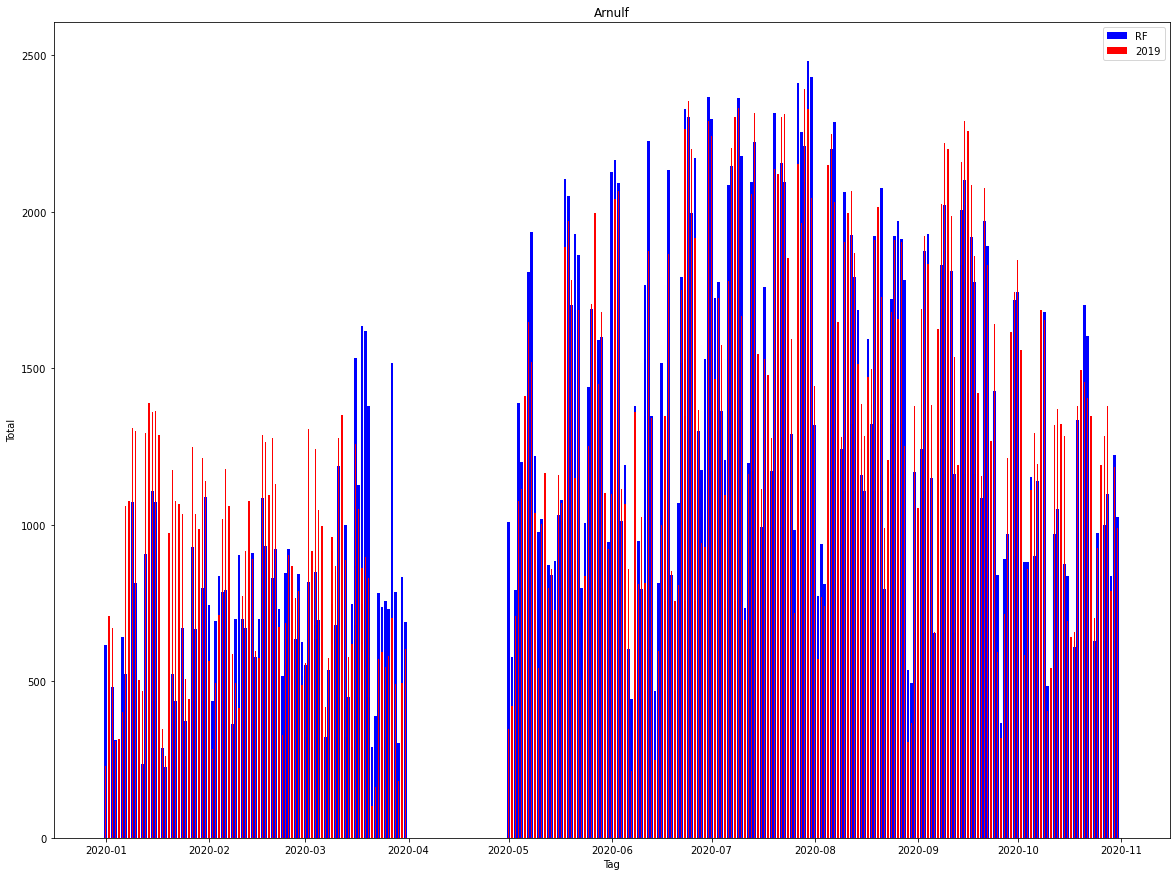

In [124]:
plotResults(df2020, preds2020RF, n=305)

## Wo passieren die gr√∂√üten Fehler?

In [125]:
df2019 = getDataframe(prefixes=('rad2019'), zaehlstelle='Arnulf')
df2019 = addMissingDays(df2019)
preds2019RF = getPredsForRF(df2019)

In [126]:
preds2019RF

date        pred
0  2019-01-01  539.538560
0  2019-01-02  517.250389
0  2019-01-03  389.990572
0  2019-01-04  406.304156
0  2019-01-05  230.376851
..        ...         ...
0  2019-12-27  510.050411
0  2019-12-28  311.407041
0  2019-12-29  308.801440
0  2019-12-30  535.916277
0  2019-12-31  741.938475

[365 rows x 2 columns]

In [127]:
df2019

uhrzeit_start  uhrzeit_ende  datumWeek zaehlstelle  richtung_1  \
2019-01-01      00:00:00         23.59          1      Arnulf       138.0   
2019-01-02      00:00:00         23.59          1      Arnulf       361.0   
2019-01-03      00:00:00         23.59          1      Arnulf       345.0   
2019-01-04      00:00:00         23.59          1      Arnulf       255.0   
2019-01-05      00:00:00         23.59          1      Arnulf        41.0   
...                  ...           ...        ...         ...         ...   
2019-12-27         00:00         23.59         52      Arnulf       312.0   
2019-12-28         00:00         23.59         52      Arnulf       337.0   
2019-12-29         00:00         23.59         52      Arnulf       253.0   
2019-12-30         00:00         23.59          1      Arnulf       550.0   
2019-12-31         00:00         23.59          1      Arnulf       329.0   

            richtung_2  gesamt  min-temp  max-temp  niederschlag  ...  \
2019-01-01        14.0   152.0       2.7       5.2           1.6  ...   
2019-01-02        30.0   391.0      -2.1       3.2           0.6  ...   
2019-01-03        32.0   377.0      -3.1      -0.6           0.0  ...   
2019-01-04        27.0   282.0      -1.7      -0.3           5.0  ...   
2019-01-05        12.0    53.0      -0.9       1.0          22.1  ...   
...                ...     ...       ...       ...           ...  ...   
2019-12-27        30.0   342.0       1.7       4.9           4.9  ...   
2019-12-28        37.0   374.0      -2.1       2.0           0.0  ...   
2019-12-29        32.0   285.0      -4.8       2.5           0.0  ...   
2019-12-30        52.0   602.0      -4.4       6.0           0.0  ...   
2019-12-31        34.0   363.0      -0.5       8.6           0.0  ...   

            datumDay  datumDayofweek datumDayofyear  datumIs_month_end  \
2019-01-01       1.0             1.0            1.0              False   
2019-01-02       2.0             2.0            2.0              False   
2019-01-03       3.0             3.0            3.0              False   
2019-01-04       4.0             4.0            4.0              False   
2019-01-05       5.0             5.0            5.0              False   
...              ...             ...            ...                ...   
2019-12-27      27.0             4.0          361.0              False   
2019-12-28      28.0             5.0          362.0              False   
2019-12-29      29.0             6.0          363.0              False   
2019-12-30      30.0             0.0          364.0              False   
2019-12-31      31.0             1.0          365.0               True   

            datumIs_month_start  datumIs_quarter_end  datumIs_quarter_start  \
2019-01-01                 True                False                   True   
2019-01-02                False                False                  False   
2019-01-03                False                False                  False   
2019-01-04                False                False                  False   
2019-01-05                False                False                  False   
...                         ...                  ...                    ...   
2019-12-27                False                False                  False   
2019-12-28                False                False                  False   
2019-12-29                False                False                  False   
2019-12-30                False                False                  False   
2019-12-31                False                 True                  False   

            datumIs_year_end  datumIs_year_start  datumElapsed  
2019-01-01             False                True    1546300800  
2019-01-02             False               False    1546387200  
2019-01-03             False               False    1546473600  
2019-01-04             False               False    1546560000  
2019-01-05             False               Fal

In [129]:
df = df2019[:2]

In [130]:
df

uhrzeit_start  uhrzeit_ende  datumWeek zaehlstelle  richtung_1  \
2019-01-01      00:00:00         23.59          1      Arnulf       138.0   
2019-01-02      00:00:00         23.59          1      Arnulf       361.0   

            richtung_2  gesamt  min-temp  max-temp  niederschlag  ...  \
2019-01-01        14.0   152.0       2.7       5.2           1.6  ...   
2019-01-02        30.0   391.0      -2.1       3.2           0.6  ...   

            datumDay  datumDayofweek datumDayofyear  datumIs_month_end  \
2019-01-01       1.0             1.0            1.0              False   
2019-01-02       2.0             2.0            2.0              False   

            datumIs_month_start  datumIs_quarter_end  datumIs_quarter_start  \
2019-01-01                 True                False                   True   
2019-01-02                False                False                  False   

            datumIs_year_end  datumIs_year_start  datumElapsed  
2019-01-01             False                True    1546300800  
2019-01-02             False               False    1546387200  

[2 rows x 25 columns]

In [131]:
dfsub = preds2019RF[:2]

In [132]:
dfsub

date        pred
0 2019-01-01  539.538560
0 2019-01-02  517.250389

In [133]:
predSeries = dfsub.set_index(dfsub.date)['pred']
dfSeries = df['gesamt']

In [134]:
predSeries, dfSeries

(date
 2019-01-01    539.538560
 2019-01-02    517.250389
 Name: pred, dtype: float64,
 2019-01-01    152.0
 2019-01-02    391.0
 Freq: D, Name: gesamt, dtype: float64)

In [135]:
dfSeries.subtract(predSeries)

2019-01-01   -387.538560
2019-01-02   -126.250389
Freq: D, dtype: float64

In [136]:
len(df2019['gesamt']), len(preds2019RF.set_index(preds2019RF.date)['pred'])

(365, 365)

In [137]:
def getPredsForRF(df):
    df = add_datepart(df, 'datum')
    results = pd.DataFrame(columns=['date', 'pred'])
    for index, x in df.iterrows():
        pred = -1
        d = x['date']
        if not pd.isnull(x['gesamt']):
            pred = rf_m.predict([x[list(xs_final.columns)]])[0]
        dfTemp = pd.DataFrame(data={'date': index, 'pred': [pred]})
        results = results.append(dfTemp)
    return results

In [138]:
df2019 = getDataframe(prefixes=('rad2019'), zaehlstelle='Arnulf')
df2019 = addMissingDays(df2019)
preds2019RF = getPredsForRF(df2019)

In [139]:
preds2019RF.loc[preds2019RF['pred'] < 1]

date  pred
0  2019-06-01  -1.0
0  2019-06-02  -1.0
0  2019-06-03  -1.0
0  2019-06-04  -1.0
0  2019-06-05  -1.0
..        ...   ...
0  2019-07-27  -1.0
0  2019-07-28  -1.0
0  2019-07-29  -1.0
0  2019-07-30  -1.0
0  2019-07-31  -1.0

[61 rows x 2 columns]

In [140]:
df2019.loc[pd.isnull(df2019['gesamt'])]

uhrzeit_start  uhrzeit_ende  datumWeek zaehlstelle  richtung_1  \
2019-06-01           NaN           NaN       <NA>         NaN         NaN   
2019-06-02           NaN           NaN       <NA>         NaN         NaN   
2019-06-03           NaN           NaN       <NA>         NaN         NaN   
2019-06-04           NaN           NaN       <NA>         NaN         NaN   
2019-06-05           NaN           NaN       <NA>         NaN         NaN   
...                  ...           ...        ...         ...         ...   
2019-07-27           NaN           NaN       <NA>         NaN         NaN   
2019-07-28           NaN           NaN       <NA>         NaN         NaN   
2019-07-29           NaN           NaN       <NA>         NaN         NaN   
2019-07-30           NaN           NaN       <NA>         NaN         NaN   
2019-07-31           NaN           NaN       <NA>         NaN         NaN   

            richtung_2  gesamt  min-temp  max-temp  niederschlag  ...  \
2019-06-01         NaN     NaN       NaN       NaN           NaN  ...   
2019-06-02         NaN     NaN       NaN       NaN           NaN  ...   
2019-06-03         NaN     NaN       NaN       NaN           NaN  ...   
2019-06-04         NaN     NaN       NaN       NaN           NaN  ...   
2019-06-05         NaN     NaN       NaN       NaN           NaN  ...   
...                ...     ...       ...       ...           ...  ...   
2019-07-27         NaN     NaN       NaN       NaN           NaN  ...   
2019-07-28         NaN     NaN       NaN       NaN           NaN  ...   
2019-07-29         NaN     NaN       NaN       NaN           NaN  ...   
2019-07-30         NaN     NaN       NaN       NaN           NaN  ...   
2019-07-31         NaN     NaN       NaN       NaN           NaN  ...   

            datumDay  datumDayofweek datumDayofyear  datumIs_month_end  \
2019-06-01       NaN             NaN            NaN              False   
2019-06-02       NaN             NaN            NaN              False   
2019-06-03       NaN             NaN            NaN              False   
2019-06-04       NaN             NaN            NaN              False   
2019-06-05       NaN             NaN            NaN              False   
...              ...             ...            ...                ...   
2019-07-27       NaN             NaN            NaN              False   
2019-07-28       NaN             NaN            NaN              False   
2019-07-29       NaN             NaN            NaN              False   
2019-07-30       NaN             NaN            NaN              False   
2019-07-31       NaN             NaN            NaN              False   

            datumIs_month_start  datumIs_quarter_end  datumIs_quarter_start  \
2019-06-01                False                False                  False   
2019-06-02                False                False                  False   
2019-06-03                False                False                  False   
2019-06-04                False                False                  False   
2019-06-05                False                False                  False   
...                         ...                  ...                    ...   
2019-07-27                False                False                  False   
2019-07-28                False                False                  False   
2019-07-29                False                False                  False   
2019-07-30                False                False                  False   
2019-07-31                False                False                  False   

            datumIs_year_end  datumIs_year_start  datumElapsed  
2019-06-01             False               False           NaN  
2019-06-02             False               False           NaN  
2019-06-03             False               False           NaN  
2019-06-04             False               False           NaN  
2019-06-05             False               Fal

In [141]:
df2019['gesamt'].replace(np.NaN, -1).loc[pd.isnull(df2019['gesamt'])]

2019-06-01   -1.0
2019-06-02   -1.0
2019-06-03   -1.0
2019-06-04   -1.0
2019-06-05   -1.0
             ... 
2019-07-27   -1.0
2019-07-28   -1.0
2019-07-29   -1.0
2019-07-30   -1.0
2019-07-31   -1.0
Freq: D, Name: gesamt, Length: 61, dtype: float64

In [142]:
errors = df2019['gesamt'].replace(np.NaN, -1).subtract(preds2019RF.set_index(preds2019RF.date)['pred'])

In [143]:
errors.sort_values(ascending=False, key=lambda x: np.abs(x))[:20]

2019-04-19   -1153.373947
2019-05-30   -1129.046604
2019-04-22   -1050.961707
2019-05-31    -878.784708
2019-05-24    -816.929535
2019-08-15    -747.233102
2019-10-22     695.011079
2019-12-05     691.892481
2019-05-01    -673.067518
2019-05-27    -661.027440
2019-09-20     652.965106
2019-05-26    -597.891397
2019-05-23    -579.376561
2019-05-25    -566.606651
2019-10-03    -538.511932
2019-11-07     522.905060
2019-04-21    -518.311352
2019-12-04     501.568605
2019-11-01    -501.416735
2019-09-27     500.063700
dtype: float64

```
2019-04-19   -1180.442298 Karfreitag
2019-05-30   -1179.176310 Christi Himmelfahrt
2019-04-22   -1059.768092 Ostermontag
2019-05-31    -954.947565 Br√ºckentag Christi Himmelfahrt
2019-08-15    -772.263989 Maria Himmelfahrt
2019-05-24    -744.230733 ?
2019-10-22     696.795180 ? 
2019-05-01    -695.081500 Schulferien Weihnachten
2019-12-05     674.750098 ?
2019-09-20     633.990541 ?
2019-05-23    -630.930030 ?
2019-05-26    -607.316037 ?
2019-10-03    -597.941322 Tag der deutschen Einheit
2019-11-01    -585.093491 Allerheiligen
2019-04-21    -565.883708 ?
2019-05-27    -565.291106 ?
2019-05-25    -544.784515 ?
2019-05-29    -538.861066 Mittwoch vor Feiertag
2019-09-27     537.904750 ?
2019-09-06     524.922845 Schulferien Sommer
```

Die gr√∂√üten Fehler beim RandomForest 2019 sind bei Feiertag. Br√ºckentag und Tage vor langen Wochenenden k√∂nnten auch noch passen

## Feiertage

F√ºr Feiertage gibt es eine API https://feiertage-api.de/

In [150]:
import requests
r = requests.get('https://feiertage-api.de/api/?jahr=2019&nur_land=BY')
json = r.json()

In [151]:
json

{'Neujahrstag': {'datum': '2019-01-01', 'hinweis': ''},
 'Heilige Drei K√∂nige': {'datum': '2019-01-06', 'hinweis': ''},
 'Karfreitag': {'datum': '2019-04-19', 'hinweis': ''},
 'Ostermontag': {'datum': '2019-04-22', 'hinweis': ''},
 'Tag der Arbeit': {'datum': '2019-05-01', 'hinweis': ''},
 'Christi Himmelfahrt': {'datum': '2019-05-30', 'hinweis': ''},
 'Pfingstmontag': {'datum': '2019-06-10', 'hinweis': ''},
 'Fronleichnam': {'datum': '2019-06-20', 'hinweis': ''},
 'Augsburger Friedensfest': {'datum': '2019-08-08',
  'hinweis': 'Das Augsburger Friedensfest ist nur im Stadtgebiet Augsburg (nicht jedoch im angrenzenden Umland) gesetzlicher Feiertag (Art. 1 Abs. 2 Bayerisches Feiertagsgesetz[7]).'},
 'Mari√§ Himmelfahrt': {'datum': '2019-08-15',
  'hinweis': 'Mari√§ Himmelfahrt ist in Bayern in von den derzeit 1704[8] (Zensus 2011, bis 2013: 1700) Gemeinden mit √ºberwiegend katholischer Bev√∂lkerung gesetzlicher Feiertag, in den restlichen 352 (Zensus 2011, bis 2013: 356) Gemeinden nicht

In [152]:
json['Neujahrstag']

{'datum': '2019-01-01', 'hinweis': ''}

In [153]:
json

{'Neujahrstag': {'datum': '2019-01-01', 'hinweis': ''},
 'Heilige Drei K√∂nige': {'datum': '2019-01-06', 'hinweis': ''},
 'Karfreitag': {'datum': '2019-04-19', 'hinweis': ''},
 'Ostermontag': {'datum': '2019-04-22', 'hinweis': ''},
 'Tag der Arbeit': {'datum': '2019-05-01', 'hinweis': ''},
 'Christi Himmelfahrt': {'datum': '2019-05-30', 'hinweis': ''},
 'Pfingstmontag': {'datum': '2019-06-10', 'hinweis': ''},
 'Fronleichnam': {'datum': '2019-06-20', 'hinweis': ''},
 'Augsburger Friedensfest': {'datum': '2019-08-08',
  'hinweis': 'Das Augsburger Friedensfest ist nur im Stadtgebiet Augsburg (nicht jedoch im angrenzenden Umland) gesetzlicher Feiertag (Art. 1 Abs. 2 Bayerisches Feiertagsgesetz[7]).'},
 'Mari√§ Himmelfahrt': {'datum': '2019-08-15',
  'hinweis': 'Mari√§ Himmelfahrt ist in Bayern in von den derzeit 1704[8] (Zensus 2011, bis 2013: 1700) Gemeinden mit √ºberwiegend katholischer Bev√∂lkerung gesetzlicher Feiertag, in den restlichen 352 (Zensus 2011, bis 2013: 356) Gemeinden nicht

In [286]:
def getFeiertage(jahre = [2017,2018,2019], bundesland = 'BY', ignore = ['Augsburger Friedensfest']):
    feiertage_df = pd.DataFrame(columns={'date','name'})
    for jahr in jahre:
        r = requests.get(f'https://feiertage-api.de/api/?jahr={jahr}&nur_land={bundesland}')
        json = r.json()
        for key, d in json.items():
            if not key in ignore:
                feiertage_df = feiertage_df.append({'date': datetime.strptime(d['datum'], "%Y-%m-%d"), 'name':key}, ignore_index=True)
    return feiertage_df

In [287]:
getFeiertage()

date                       name
0  2017-01-01                Neujahrstag
1  2017-01-06        Heilige Drei K√∂nige
2  2017-04-14                 Karfreitag
3  2017-04-17                Ostermontag
4  2017-05-01             Tag der Arbeit
5  2017-05-25        Christi Himmelfahrt
6  2017-06-05              Pfingstmontag
7  2017-06-15               Fronleichnam
8  2017-08-15          Mari√§ Himmelfahrt
9  2017-10-03  Tag der Deutschen Einheit
10 2017-10-31            Reformationstag
11 2017-11-01              Allerheiligen
12 2017-11-22            Bu√ü- und Bettag
13 2017-12-25           1. Weihnachtstag
14 2017-12-26           2. Weihnachtstag
15 2018-01-01                Neujahrstag
16 2018-01-06        Heilige Drei K√∂nige
17 2018-03-30                 Karfreitag
18 2018-04-02                Ostermontag
19 2018-05-01             Tag der Arbeit
20 2018-05-10        Christi Himmelfahrt
21 2018-05-21              Pfingstmontag
22 2018-05-31               Fronleichnam
23 2018-08-15          Mari√§ Himmelfahrt
24 2018-10-03  Tag der Deutschen Einheit
25 2018-11-01              Allerheiligen
26 2018-11-21            Bu√ü- und Bettag
27 2018-12-25           1. Weihnachtstag
28 2018-12-26           2. Weihnachtstag
29 2019-01-01                Neujahrstag
30 2019-01-06        Heilige Drei K√∂nige
31 2019-04-19                 Karfreitag
32 2019-04-22                Ostermontag
33 2019-05-01             Tag der Arbeit
34 2019-05-30        Christi Himmelfahrt
35 2019-06-10              Pfingstmontag
36 2019-06-20               Fronleichnam
37 2019-08-15          Mari√§ Himmelfahrt
38 2019-10-03  Tag der Deutschen Einheit
39 2019-11-01              Allerheiligen
40 2019-11-20            Bu√ü- und Bettag
41 2019-12-25           1. Weihnachtstag
42 2019-12-26           2. Weihnachtstag

## Get Schulferien

Auch hier gibt es eine offene Api: https://ferien-api.de/

In [163]:
r = requests.get('https://ferien-api.de/api/v1/holidays/BY/2019')
json = r.json()

In [164]:
json

[{'start': '2019-03-04T00:00Z',
  'end': '2019-03-09T00:00Z',
  'year': 2019,
  'stateCode': 'BY',
  'name': 'winterferien',
  'slug': 'winterferien-2019-BY'},
 {'start': '2019-04-15T00:00Z',
  'end': '2019-04-28T00:00Z',
  'year': 2019,
  'stateCode': 'BY',
  'name': 'osterferien',
  'slug': 'osterferien-2019-BY'},
 {'start': '2019-06-11T00:00Z',
  'end': '2019-06-22T00:00Z',
  'year': 2019,
  'stateCode': 'BY',
  'name': 'pfingstferien',
  'slug': 'pfingstferien-2019-BY'},
 {'start': '2019-07-29T00:00Z',
  'end': '2019-09-10T00:00Z',
  'year': 2019,
  'stateCode': 'BY',
  'name': 'sommerferien',
  'slug': 'sommerferien-2019-BY'},
 {'start': '2019-10-28T00:00Z',
  'end': '2019-11-01T00:00Z',
  'year': 2019,
  'stateCode': 'BY',
  'name': 'herbstferien',
  'slug': 'herbstferien-2019-BY'},
 {'start': '2019-12-23T00:00Z',
  'end': '2020-01-05T00:00Z',
  'year': 2019,
  'stateCode': 'BY',
  'name': 'weihnachtsferien',
  'slug': 'weihnachtsferien-2019-BY'}]

In [288]:
def getFerientage(bundesland = 'BY', jahre = [2017,2018,2019]):
    ferientage_df = pd.DataFrame(columns={'date', 'name'})
    for jahr in jahre:
        r = requests.get(f'https://ferien-api.de/api/v1/holidays/{bundesland}/{jahr}')
        json = r.json()

        for f in json:
            start = datetime.strptime(f['start'], '%Y-%m-%dT%H:%MZ')
            end = datetime.strptime(f['end'], '%Y-%m-%dT%H:%MZ')
            dates = pd.date_range(start, end)

            df = pd.DataFrame({'date': dates, 'name':f['name']})

            ferientage_df = ferientage_df.append(df)
    return ferientage_df

In [289]:
getFerientage()

date              name
0  2017-02-27      winterferien
1  2017-02-28      winterferien
2  2017-03-01      winterferien
3  2017-03-02      winterferien
4  2017-03-03      winterferien
..        ...               ...
9  2020-01-01  weihnachtsferien
10 2020-01-02  weihnachtsferien
11 2020-01-03  weihnachtsferien
12 2020-01-04  weihnachtsferien
13 2020-01-05  weihnachtsferien

[292 rows x 2 columns]

## Add as additional features

In [290]:
feiertage_df = getFeiertage()
ferientage_df = getFerientage()

In [291]:
df = getDataframe(prefixes=('rad2019'), zaehlstelle='Arnulf')
df['date'] = pd.to_datetime(df['datum'], format="%Y.%m.%d")
df = add_datepart(df, 'datum')

In [292]:
df[:1]

uhrzeit_start  uhrzeit_ende  datumWeek zaehlstelle  richtung_1  richtung_2  \
0      00:00:00         23.59          1      Arnulf         138          14   

   gesamt  min-temp  max-temp  niederschlag  ...  datumDay  datumDayofweek  \
0     152       2.7       5.2           1.6  ...         1               1   

  datumDayofyear  datumIs_month_end  datumIs_month_start  datumIs_quarter_end  \
0              1              False                 True                False   

   datumIs_quarter_start  datumIs_year_end  datumIs_year_start  datumElapsed  
0                   True             False                True    1546300800  

[1 rows x 25 columns]

In [293]:
df['date'][:1]

0   2019-01-01
Name: date, dtype: datetime64[ns]

In [294]:
feiertage_df['date']

0    2017-01-01
1    2017-01-06
2    2017-04-14
3    2017-04-17
4    2017-05-01
5    2017-05-25
6    2017-06-05
7    2017-06-15
8    2017-08-15
9    2017-10-03
10   2017-10-31
11   2017-11-01
12   2017-11-22
13   2017-12-25
14   2017-12-26
15   2018-01-01
16   2018-01-06
17   2018-03-30
18   2018-04-02
19   2018-05-01
20   2018-05-10
21   2018-05-21
22   2018-05-31
23   2018-08-15
24   2018-10-03
25   2018-11-01
26   2018-11-21
27   2018-12-25
28   2018-12-26
29   2019-01-01
30   2019-01-06
31   2019-04-19
32   2019-04-22
33   2019-05-01
34   2019-05-30
35   2019-06-10
36   2019-06-20
37   2019-08-15
38   2019-10-03
39   2019-11-01
40   2019-11-20
41   2019-12-25
42   2019-12-26
Name: date, dtype: datetime64[ns]

In [295]:
df['is_feiertag'] = False
df.loc[df['date'].isin(feiertage_df['date']), 'is_feiertag'] = True

In [296]:
df.loc[df['is_feiertag'] == True]['date']

0    2019-01-01
5    2019-01-06
18   2019-04-19
21   2019-04-22
0    2019-05-01
29   2019-05-30
14   2019-08-15
2    2019-10-03
0    2019-11-01
19   2019-11-20
24   2019-12-25
25   2019-12-26
Name: date, dtype: datetime64[ns]

In [297]:
def add_date_feature(df, name, dates):
    df[name] = False
    df.loc[df['date'].isin(dates), name] = True

In [298]:
df = getDataframe(prefixes=('rad2019'), zaehlstelle='Arnulf')
df['date'] = pd.to_datetime(df['datum'], format="%Y.%m.%d")
df = add_datepart(df, 'datum')
add_date_feature(df, 'feiertag', feiertage_df['date'])
add_date_feature(df, 'ferientag', ferientage_df['date'])
df

uhrzeit_start  uhrzeit_ende  datumWeek zaehlstelle  richtung_1  richtung_2  \
0       00:00:00         23.59          1      Arnulf         138          14   
1       00:00:00         23.59          1      Arnulf         361          30   
2       00:00:00         23.59          1      Arnulf         345          32   
3       00:00:00         23.59          1      Arnulf         255          27   
4       00:00:00         23.59          1      Arnulf          41          12   
..           ...           ...        ...         ...         ...         ...   
26         00:00         23.59         52      Arnulf         312          30   
27         00:00         23.59         52      Arnulf         337          37   
28         00:00         23.59         52      Arnulf         253          32   
29         00:00         23.59          1      Arnulf         550          52   
30         00:00         23.59          1      Arnulf         329          34   

    gesamt  min-temp  max-temp  niederschlag  ...  datumDayofyear  \
0      152       2.7       5.2           1.6  ...               1   
1      391      -2.1       3.2           0.6  ...               2   
2      377      -3.1      -0.6           0.0  ...               3   
3      282      -1.7      -0.3           5.0  ...               4   
4       53      -0.9       1.0          22.1  ...               5   
..     ...       ...       ...           ...  ...             ...   
26     342       1.7       4.9           4.9  ...             361   
27     374      -2.1       2.0           0.0  ...             362   
28     285      -4.8       2.5           0.0  ...             363   
29     602      -4.4       6.0           0.0  ...             364   
30     363      -0.5       8.6           0.0  ...             365   

    datumIs_month_end datumIs_month_start  datumIs_quarter_end  \
0               False                True                False   
1               False               False                False   
2               False               False                False   
3               False               False                False   
4               False               False                False   
..                ...                 ...                  ...   
26              False               False                False   
27              False               False                False   
28              False               False                False   
29              False               False                False   
30               True               False                 True   

    datumIs_quarter_start  datumIs_year_end  datumIs_year_start  datumElapsed  \
0                    True             False                True    1546300800   
1                   False             False               False    1546387200   
2                   False             False               False    1546473600   
3                   False             False               False    1546560000   
4                   False             False               False    1546646400   
..                    ...               ...                 ...           ...   
26                  False             False               False    1577404800   
27                  False             False               False    1577491200   
28                  False             False               False    1577577600   
29                  False             False               False    1577664000   
30                  False              True               False    1577750400   

    feiertag  ferientag  
0       True       True  
1      False       True  
2      False       True  
3      False       True  
4      False       True  
..       ...        ...  
26     False       True  
27     False       True  
28     False       True  
29     False       True  
30     False       True  

[304 rows x 27 columns]

## Train Randomforest with new data

In [626]:
dep_var = 'gesamt' # dependent variable, the number we want to predict
usedColumns = np.append(xs_final.columns.values, ['feiertag', 'ferientag'])

In [627]:
df = getDataframe(zaehlstelle='Arnulf', prefixes = ('rad2017', 'rad2018', 'rad2019'))
df['date'] = pd.to_datetime(df['datum'], format="%Y.%m.%d")
df = add_datepart(df, 'datum')
add_date_feature(df, 'feiertag', feiertage_df['date'])
add_date_feature(df, 'ferientag', ferientage_df['date'])
df = df.drop(['richtung_1', 'richtung_2'], axis=1)
# df = df[list(usedColumns) + [dep_var]] reduce columns after train valid set is created because year is used
df

uhrzeit_start uhrzeit_ende  datumWeek zaehlstelle  gesamt  min-temp  \
0       00:00:00        23.59         52      Arnulf     135      -6.1   
1       00:00:00        23.59          1      Arnulf     400      -5.4   
2       00:00:00        23.59          1      Arnulf     262      -2.1   
3       00:00:00        23.59          1      Arnulf     207      -0.9   
4       00:00:00        23.59          1      Arnulf     224      -7.1   
..           ...          ...        ...         ...     ...       ...   
26         00:00        23.59         52      Arnulf     342       1.7   
27         00:00        23.59         52      Arnulf     374      -2.1   
28         00:00        23.59         52      Arnulf     285      -4.8   
29         00:00        23.59          1      Arnulf     602      -4.4   
30         00:00        23.59          1      Arnulf     363      -0.5   

    max-temp  niederschlag  bewoelkung  sonnenstunden  ... datumDayofyear  \
0        2.6           0.0          36            5.9  ...              1   
1        0.8           3.2          69            0.3  ...              2   
2        0.6           0.0          85            3.6  ...              3   
3        1.3           2.2          94            0.0  ...              4   
4       -0.2           0.0          88            0.0  ...              5   
..       ...           ...         ...            ...  ...            ...   
26       4.9           4.9          98            0.0  ...            361   
27       2.0           0.0          69            3.2  ...            362   
28       2.5           0.0          26            7.9  ...            363   
29       6.0           0.0           9            8.0  ...            364   
30       8.6           0.0          60            6.8  ...            365   

    datumIs_month_end  datumIs_month_start  datumIs_quarter_end  \
0               False                 True                False   
1               False                False                False   
2               False                False                False   
3               False                False                False   
4               False                False                False   
..                ...                  ...                  ...   
26              False                False                False   
27              False                False                False   
28              False                False                False   
29              False                False                False   
30               True                False                 True   

    datumIs_quarter_start  datumIs_year_end  datumIs_year_start  datumElapsed  \
0                    True             False                True    1483228800   
1                   False             False               False    1483315200   
2                   False             False               False    1483401600   
3                   False             False               False    1483488000   
4                   False             False               False    1483574400   
..                    ...               ...                 ...           ...   
26                  False             False               False    1577404800   
27                  False             False               False    1577491200   
28                  False             False               False    1577577600   
29                  False             False               False    1577664000   
30                  False              True               False    1577750400   

    feiertag  ferientag  
0       True      False  
1      False      False  
2      False      False  
3      False      False  
4      False      False  
..       ...        ...  
26     False       True  
27     False       True  
28     False       True  
29     False       True  
30     False       True  

[1034 rows x 25 columns]

In [628]:
# Create Tabular Pandas
procs = [Categorify, FillMissing] # processings or transformations
cond = (df.datumYear<2019)
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]
splits = (list(train_idx),list(valid_idx))

cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [629]:
xs,y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [630]:
xs = xs[list(usedColumns)]
valid_xs = valid_xs[list(usedColumns)]

In [631]:
xs[:1]

max-temp  datumDayofweek  min-temp  sonnenstunden  datumDayofyear  \
0       2.6               6      -6.1            5.9               1   

   bewoelkung  datumWeek  niederschlag  datumDay  feiertag  ferientag  
0          36         52           0.0         1         2          1

In [632]:
m = rf(xs,y)

In [633]:
m_rmse(m, valid_xs, valid_y)

281.425576

üò≥better then version without holidays: run 273 vs 287

In [634]:
fi = rf_feat_importance(m, xs)
fi

cols       imp
0         max-temp  0.377267
1   datumDayofweek  0.191068
3    sonnenstunden  0.165056
2         min-temp  0.114389
4   datumDayofyear  0.038109
5       bewoelkung  0.031939
6        datumWeek  0.031694
7     niederschlag  0.027409
8         datumDay  0.009056
10       ferientag  0.008801
9         feiertag  0.005213

In [635]:
rf_pred = m.predict(valid_xs)

In [641]:
len(rf_pred), len(valid_y)

(304, 304)

In [650]:
error = np.subtract(rf_pred, valid_y).abs()

In [652]:
df_errors = df.iloc[valid_idx]
df_errors['pred'] = rf_pred
df_errors['error'] = error
df_errors.columns

Index(['uhrzeit_start', 'uhrzeit_ende', 'datumWeek', 'zaehlstelle', 'gesamt',
       'min-temp', 'max-temp', 'niederschlag', 'bewoelkung', 'sonnenstunden',
       'date', 'datumYear', 'datumMonth', 'datumDay', 'datumDayofweek',
       'datumDayofyear', 'datumIs_month_end', 'datumIs_month_start',
       'datumIs_quarter_end', 'datumIs_quarter_start', 'datumIs_year_end',
       'datumIs_year_start', 'datumElapsed', 'feiertag', 'ferientag', 'pred',
       'error'],
      dtype='object')

In [668]:
df_errors.sort_values(by = 'error', ascending=False)[['date', 'datumDayofweek', 'min-temp', 'feiertag', 'ferientag', 'error', 'gesamt', 'pred']][:30]

date  datumDayofweek  min-temp  feiertag  ferientag        error  \
18 2019-04-19               4       5.5      True       True  1144.246959   
29 2019-05-30               3       8.6      True      False  1089.537144   
21 2019-04-22               0       6.5      True       True   954.309239   
30 2019-05-31               4      11.7     False      False   842.117085   
0  2019-05-01               2       4.7      True      False   775.988006   
26 2019-05-27               0      11.2     False      False   750.276638   
23 2019-05-24               4       6.3     False      False   747.065509   
14 2019-08-15               3       9.8      True       True   735.142770   
4  2019-12-05               3      -4.8     False      False   677.478520   
25 2019-05-26               6      12.1     False      False   635.670001   
22 2019-05-23               3       7.6     False      False   618.415755   
24 2019-05-25               5      10.5     False      False   600.788260   
21 2019-10-22               1      10.5     False      False   600.256773   
28 2019-05-29               2       9.4     False      False   566.276569   
19 2019-09-20               4       3.4     False      False   546.019065   
16 2019-05-17               4       5.5     False      False   545.859561   
10 2019-12-11               2      -3.8     False      False   515.635139   
21 2019-05-22               2       8.8     False      False   502.276762   
23 2019-12-24               1       3.7     False       True   489.876867   
7  2019-08-08               3      15.0     False       True   488.345628   
0  2019-08-01               3      13.4     False       True   486.287097   
18 2019-10-19               5       8.5     False      False   471.301617   
20 2019-04-21               6       4.6     False       True   469.279778   
6  2019-11-07               3       2.3     False      False   462.899650   
22 2019-08-23               4      11.4     False       True   457.200298   
26 2019-09-27               4      13.7     False      False   454.119402   
25 2019-09-26               3      12.6     False      False   452.606530   
5  2019-09-06               4      10.6     False       True   450.428064   
2  2019-10-03               3       5.3      True      False   446.927990   
3  2019-12-04               2      -2.9     False      False   444.973172   

    gesamt         pred  
18     785  1929.246959  
29     593  1682.537144  
21     843  1797.309239  
30     751  1593.117085  
0     1061  1836.988006  
26     817  1567.276638  
23    1194  1941.065509  
14     769  1504.142770  
4     1381   703.521480  
25     518  1153.670001  
22    1239  1857.415755  
24     506  1106.788260  
21    1873  1272.743227  
28     722  1288.276569  
19    2011  1464.980935  
16    1299  1844.859561  
10    1259   743.364861  
21     669  1171.276762  
23     217   706.876867  
7     2354  1865.654372  
0     2500  2013.712903  
18    1130   658.698383  
20     609  1078.279778  
6     1685  1222.100350  
22    1778  1320.799702  
26    1950  1495.880598  
25    1826  1373.393470  
5     1416   965.571936  
2      750  1196.927990  
3     1292   847.026828

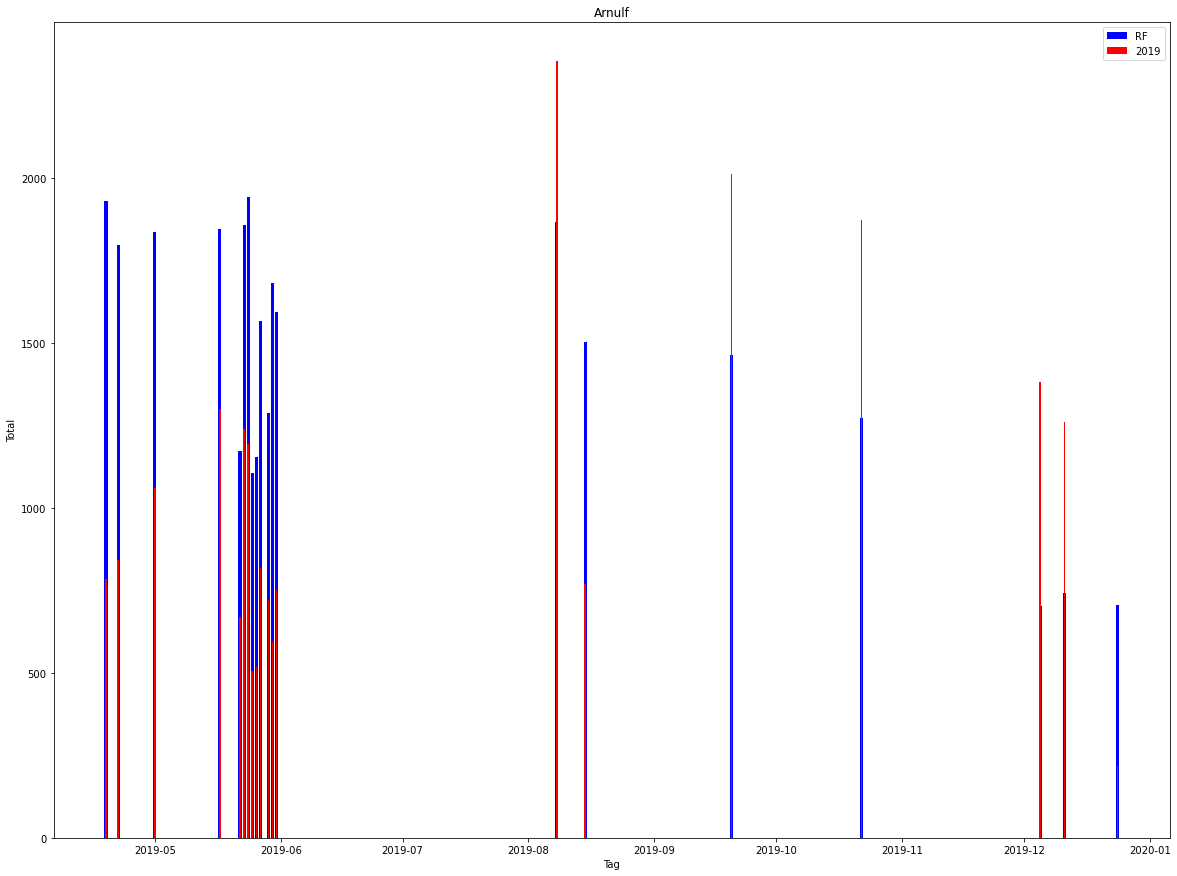

In [670]:
top_errors = df_errors.sort_values(by = 'error', ascending=False)[:20]
plotResults(top_errors, top_errors)

Wie beim NN auch im Mai Fehler.

## Check with neuronal Net

In [525]:
usedColumns

array(['max-temp', 'datumDayofweek', 'min-temp', 'sonnenstunden',
       'datumDayofyear', 'bewoelkung', 'datumWeek', 'niederschlag',
       'feiertag', 'ferientag'], dtype=object)

In [526]:
usedColumns[usedColumns!='datumDay']

array(['max-temp', 'datumDayofweek', 'min-temp', 'sonnenstunden',
       'datumDayofyear', 'bewoelkung', 'datumWeek', 'niederschlag',
       'feiertag', 'ferientag'], dtype=object)

In [527]:
usedColumns = usedColumns[usedColumns!='datumDay']

df_nn = getDataframe(zaehlstelle='Arnulf', prefixes = ('rad2017', 'rad2018', 'rad2019'))
df_nn['date'] = pd.to_datetime(df_nn['datum'], format="%Y.%m.%d")
df_nn = add_datepart(df_nn, 'datum')
add_date_feature(df_nn, 'feiertag', feiertage_df['date'])
add_date_feature(df_nn, 'ferientag', ferientage_df['date'])
df_nn = df_nn.drop(['richtung_1', 'richtung_2'], axis=1)
df_full = df_nn
df_nn = df_nn[list(usedColumns) + [dep_var]] #reduce columns after train valid set is created because year is used
df_nn

max-temp  datumDayofweek  min-temp  sonnenstunden  datumDayofyear  \
0        2.6               6      -6.1            5.9               1   
1        0.8               0      -5.4            0.3               2   
2        0.6               1      -2.1            3.6               3   
3        1.3               2      -0.9            0.0               4   
4       -0.2               3      -7.1            0.0               5   
..       ...             ...       ...            ...             ...   
26       4.9               4       1.7            0.0             361   
27       2.0               5      -2.1            3.2             362   
28       2.5               6      -4.8            7.9             363   
29       6.0               0      -4.4            8.0             364   
30       8.6               1      -0.5            6.8             365   

    bewoelkung  datumWeek  niederschlag  feiertag  ferientag  gesamt  
0           36         52           0.0      True      False     135  
1           69          1           3.2     False      False     400  
2           85          1           0.0     False      False     262  
3           94          1           2.2     False      False     207  
4           88          1           0.0     False      False     224  
..         ...        ...           ...       ...        ...     ...  
26          98         52           4.9     False       True     342  
27          69         52           0.0     False       True     374  
28          26         52           0.0     False       True     285  
29           9          1           0.0     False       True     602  
30          60          1           0.0     False       True     363  

[1034 rows x 11 columns]

In [528]:
cont_nn, cat_nn = cont_cat_split(df_nn, dep_var=dep_var)
#cont_nn.append('bewoelkung')
#cat_nn.remove('bewoelkung')

In [529]:
cont_nn, cat_nn

(['max-temp',
  'min-temp',
  'sonnenstunden',
  'datumDayofyear',
  'bewoelkung',
  'niederschlag'],
 ['datumDayofweek', 'datumWeek', 'feiertag', 'ferientag'])

In [530]:
df_nn[cat_nn].nunique()

datumDayofweek     7
datumWeek         52
feiertag           2
ferientag          2
dtype: int64

In [531]:
df_nn=df_nn.astype('float')
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn, procs_nn, cat_nn, cont_nn, splits=splits, y_names=dep_var)
dls = to_nn.dataloaders()
y = to_nn.train.y
y.min(), y.max()

(29.0, 2707.0)

In [597]:
learn = tabular_learner(dls, n_out=1, loss_func=F.mse_loss)

In [598]:
learn.fit_one_cycle(20, 1e-2)

In [599]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

253.787389

Also better: 253 vs 287

In [600]:
preds

tensor([[  84.9261],
        [ 359.4824],
        [ 355.8282],
        [  83.5819],
        [ 261.0335],
        [ 261.0335],
        [ 674.5120],
        [ 701.4084],
        [ 331.3350],
        [ 639.6132],
        [ 503.3195],
        [ 162.7219],
        [ 250.9682],
        [ 425.3148],
        [ 581.2552],
        [ 905.8975],
        [ 737.0085],
        [ 393.3682],
        [ 263.1782],
        [ 261.0335],
        [ 401.2321],
        [ 507.4619],
        [ 435.4880],
        [ 549.2615],
        [ 343.4608],
        [ 261.4726],
        [ 262.8838],
        [ 768.0575],
        [ 854.8180],
        [ 788.5484],
        [ 974.8979],
        [ 634.3961],
        [ 234.8873],
        [ 255.0909],
        [ 795.2490],
        [1007.6334],
        [ 802.8148],
        [ 781.4431],
        [1194.6355],
        [ 519.0215],
        [ 538.8396],
        [ 453.7399],
        [ 640.6326],
        [ 878.5571],
        [ 923.5356],
        [ 955.4264],
        [ 479.4608],
        [ 341

In [601]:
targs

tensor([[ 152.],
        [ 391.],
        [ 377.],
        [ 282.],
        [  53.],
        [ 107.],
        [ 514.],
        [ 581.],
        [ 417.],
        [ 175.],
        [ 140.],
        [  52.],
        [ 101.],
        [ 552.],
        [ 517.],
        [ 729.],
        [ 795.],
        [ 640.],
        [ 280.],
        [ 193.],
        [ 695.],
        [ 720.],
        [ 743.],
        [ 764.],
        [ 520.],
        [ 187.],
        [ 215.],
        [ 806.],
        [ 716.],
        [ 755.],
        [ 869.],
        [ 762.],
        [ 256.],
        [  36.],
        [ 254.],
        [ 439.],
        [ 485.],
        [ 491.],
        [ 629.],
        [ 277.],
        [ 295.],
        [ 527.],
        [ 727.],
        [ 933.],
        [ 945.],
        [ 992.],
        [ 580.],
        [ 575.],
        [1154.],
        [1277.],
        [1158.],
        [1215.],
        [ 678.],
        [ 490.],
        [ 419.],
        [1214.],
        [1378.],
        [1351.],
        [1348.

In [602]:
valid_idx

array([ 730,  731,  732,  733,  734,  735,  736,  737,  738,  739,  740,
        741,  742,  743,  744,  745,  746,  747,  748,  749,  750,  751,
        752,  753,  754,  755,  756,  757,  758,  759,  760,  761,  762,
        763,  764,  765,  766,  767,  768,  769,  770,  771,  772,  773,
        774,  775,  776,  777,  778,  779,  780,  781,  782,  783,  784,
        785,  786,  787,  788,  789,  790,  791,  792,  793,  794,  795,
        796,  797,  798,  799,  800,  801,  802,  803,  804,  805,  806,
        807,  808,  809,  810,  811,  812,  813,  814,  815,  816,  817,
        818,  819,  820,  821,  822,  823,  824,  825,  826,  827,  828,
        829,  830,  831,  832,  833,  834,  835,  836,  837,  838,  839,
        840,  841,  842,  843,  844,  845,  846,  847,  848,  849,  850,
        851,  852,  853,  854,  855,  856,  857,  858,  859,  860,  861,
        862,  863,  864,  865,  866,  867,  868,  869,  870,  871,  872,
        873,  874,  875,  876,  877,  878,  879,  8

In [603]:
df_try = df_full.iloc[valid_idx]
df_try

uhrzeit_start uhrzeit_ende  datumWeek zaehlstelle  gesamt  min-temp  \
0       00:00:00        23.59          1      Arnulf     152       2.7   
1       00:00:00        23.59          1      Arnulf     391      -2.1   
2       00:00:00        23.59          1      Arnulf     377      -3.1   
3       00:00:00        23.59          1      Arnulf     282      -1.7   
4       00:00:00        23.59          1      Arnulf      53      -0.9   
5       00:00:00        23.59          1      Arnulf     107       0.7   
6       00:00:00        23.59          2      Arnulf     514       0.7   
7       00:00:00        23.59          2      Arnulf     581       0.8   
8       00:00:00        23.59          2      Arnulf     417      -1.5   
9       00:00:00        23.59          2      Arnulf     175      -3.5   
10      00:00:00        23.59          2      Arnulf     140      -4.1   
11      00:00:00        23.59          2      Arnulf      52      -1.1   
12      00:00:00        23.59          2      Arnulf     101       1.4   
13      00:00:00        23.59          3      Arnulf     552      -0.1   
14      00:00:00        23.59          3      Arnulf     517      -0.8   
15      00:00:00        23.59          3      Arnulf     729      -0.9   
16      00:00:00        23.59          3      Arnulf     795       1.9   
17      00:00:00        23.59          3      Arnulf     640      -2.9   
18      00:00:00        23.59          3      Arnulf     280      -6.0   
19      00:00:00        23.59          3      Arnulf     193      -8.0   
20      00:00:00        23.59          4      Arnulf     695      -3.5   
21      00:00:00        23.59          4      Arnulf     720      -5.1   
22      00:00:00        23.59          4      Arnulf     743      -5.0   
23      00:00:00        23.59          4      Arnulf     764      -4.4   
24      00:00:00        23.59          4      Arnulf     520      -4.7   
25      00:00:00        23.59          4      Arnulf     187      -3.1   
26      00:00:00        23.59          4      Arnulf     215       2.1   
27      00:00:00        23.59          5      Arnulf     806       0.2   
28      00:00:00        23.59          5      Arnulf     716      -2.9   
29      00:00:00        23.59          5      Arnulf     755      -4.6   
30      00:00:00        23.59          5      Arnulf     869      -3.6   
0       00:00:00        23.59          5      Arnulf     762      -0.2   
1       00:00:00        23.59          5      Arnulf     256       0.7   
2       00:00:00        23.59          5      Arnulf      36      -1.5   
3       00:00:00        23.59          6      Arnulf     254      -4.5   
4       00:00:00        23.59          6      Arnulf     439      -3.9   
5       00:00:00        23.59          6      Arnulf     485      -6.6   
6       00:00:00        23.59          6      Arnulf     491      -5.6   
7       00:00:00        23.59          6      Arnulf     629       1.7   
8       00:00:00        23.59          6      Arnulf     277       0.8   
9       00:00:00        23.59          6      Arnulf     295       4.1   
10      00:00:00        23.59          7      Arnulf     527       0.0   
11      00:00:00        23.59          7      Arnulf     727      -0.1   
12      00:00:00        23.59          7      Arnulf     933      -0.9   
13      00:00:00        23.59          7      Arnulf     945      -1.5   
14      00:00:00        23.59          7      Arnulf     992      -1.4   
15      00:00:00        23.59          7      Arnulf     580      -2.1   
16      00:00:00        23.59          7      Arnulf     575      -1.7   
17      00:00:00        23.59          8      Arnulf    1154      -1.8   
18      00:00:00        23.59          8      Arnulf    1277       1.0   
19      00:00:00        23.59          8      Arnulf    1158       5.0   
20      00:00:00        23.59          8      Arnulf    1215       4.1   
21      00:00:00        23.59          8      Arnulf     678       2.7   
22     

In [604]:
errors = pd.DataFrame(torch.sub(preds, targs).abs().numpy())
errors.values

array([[6.70739365e+01],
       [3.15176392e+01],
       [2.11717529e+01],
       [1.98418137e+02],
       [2.08033508e+02],
       [1.54033508e+02],
       [1.60511963e+02],
       [1.20408447e+02],
       [8.56649780e+01],
       [4.64613159e+02],
       [3.63319458e+02],
       [1.10721939e+02],
       [1.49968170e+02],
       [1.26685181e+02],
       [6.42552490e+01],
       [1.76897461e+02],
       [5.79914551e+01],
       [2.46631775e+02],
       [1.68218384e+01],
       [6.80335083e+01],
       [2.93767944e+02],
       [2.12538147e+02],
       [3.07511963e+02],
       [2.14738525e+02],
       [1.76539185e+02],
       [7.44726257e+01],
       [4.78837891e+01],
       [3.79425049e+01],
       [1.38817993e+02],
       [3.35484009e+01],
       [1.05897888e+02],
       [1.27603943e+02],
       [2.11126556e+01],
       [2.19090866e+02],
       [5.41249023e+02],
       [5.68633423e+02],
       [3.17814819e+02],
       [2.90443054e+02],
       [5.65635498e+02],
       [2.42021484e+02],


In [605]:
pd.options.mode.chained_assignment = None
df_try['error'] = errors.to_numpy()
df_try['pred'] = preds.numpy()

In [608]:
df_try

uhrzeit_start uhrzeit_ende  datumWeek zaehlstelle  gesamt  min-temp  \
0       00:00:00        23.59          1      Arnulf     152       2.7   
1       00:00:00        23.59          1      Arnulf     391      -2.1   
2       00:00:00        23.59          1      Arnulf     377      -3.1   
3       00:00:00        23.59          1      Arnulf     282      -1.7   
4       00:00:00        23.59          1      Arnulf      53      -0.9   
..           ...          ...        ...         ...     ...       ...   
26         00:00        23.59         52      Arnulf     342       1.7   
27         00:00        23.59         52      Arnulf     374      -2.1   
28         00:00        23.59         52      Arnulf     285      -4.8   
29         00:00        23.59          1      Arnulf     602      -4.4   
30         00:00        23.59          1      Arnulf     363      -0.5   

    max-temp  niederschlag  bewoelkung  sonnenstunden  ...  \
0        5.2           1.6          99            0.0  ...   
1        3.2           0.6          88            0.7  ...   
2       -0.6           0.0          93            2.9  ...   
3       -0.3           5.0          96            0.0  ...   
4        1.0          22.1          95            0.0  ...   
..       ...           ...         ...            ...  ...   
26       4.9           4.9          98            0.0  ...   
27       2.0           0.0          69            3.2  ...   
28       2.5           0.0          26            7.9  ...   
29       6.0           0.0           9            8.0  ...   
30       8.6           0.0          60            6.8  ...   

   datumIs_month_start  datumIs_quarter_end  datumIs_quarter_start  \
0                 True                False                   True   
1                False                False                  False   
2                False                False                  False   
3                False                False                  False   
4                False                False                  False   
..                 ...                  ...                    ...   
26               False                False                  False   
27               False                False                  False   
28               False                False                  False   
29               False                False                  False   
30               False                 True                  False   

    datumIs_year_end  datumIs_year_start  datumElapsed  feiertag  ferientag  \
0              False                True    1546300800      True       True   
1              False               False    1546387200     False       True   
2              False               False    1546473600     False       True   
3              False               False    1546560000     False       True   
4              False               False    1546646400     False       True   
..               ...                 ...           ...       ...        ...   
26             False               False    1577404800     False       True   
27             False               False    1577491200     False       True   
28             False               False    1577577600     False       True   
29             False               False    1577664000     False       True   
30              True               False    1577750400     False       True   

         error        pred  
0    67.073936   84.926064  
1    31.517639  359.482361  
2    21.171753  355.828247  
3   198.418137   83.581863  
4   208.033508  261.033508  
..         ...         ...  
26   77.732361  264.267639  
27  112.966492  261.033508  
28   23.966492  261.033508  
29   43.203064  645.203064  
30  255.304565  618.304565  

[304 rows x 27 columns]

In [609]:
df_try.columns

Index(['uhrzeit_start', 'uhrzeit_ende', 'datumWeek', 'zaehlstelle', 'gesamt',
       'min-temp', 'max-temp', 'niederschlag', 'bewoelkung', 'sonnenstunden',
       'date', 'datumYear', 'datumMonth', 'datumDay', 'datumDayofweek',
       'datumDayofyear', 'datumIs_month_end', 'datumIs_month_start',
       'datumIs_quarter_end', 'datumIs_quarter_start', 'datumIs_year_end',
       'datumIs_year_start', 'datumElapsed', 'feiertag', 'ferientag', 'error',
       'pred'],
      dtype='object')

In [610]:
pd.set_option('display.max_rows', 500)
df_try.sort_values(by = 'error', ascending=False)[['date', 'datumDayofweek', 'min-temp', 'feiertag', 'ferientag', 'error', 'gesamt', 'pred']]

date  datumDayofweek  min-temp  feiertag  ferientag       error  \
22 2019-05-23               3       7.6     False      False  829.750000   
23 2019-05-24               4       6.3     False      False  811.076782   
30 2019-05-31               4      11.7     False      False  765.695190   
21 2019-05-22               2       8.8     False      False  712.133301   
20 2019-05-21               1      10.5     False      False  707.684937   
28 2019-05-29               2       9.4     False      False  706.580078   
27 2019-05-28               1       9.5     False      False  702.638794   
0  2019-10-01               1       9.6     False      False  685.092163   
25 2019-08-26               0      16.1     False       True  655.218689   
22 2019-08-23               4      11.4     False       True  607.220337   
26 2019-05-27               0      11.2     False      False  604.526001   
1  2019-10-02               2       5.9     False      False  592.928955   
4  2019-02-05               1      -3.9     False      False  568.633423   
7  2019-02-08               4       1.7     False      False  565.635498   
24 2019-05-25               5      10.5     False      False  564.137451   
21 2019-08-22               3      13.0     False       True  561.350952   
3  2019-02-04               0      -4.5     False      False  541.249023   
15 2019-12-16               0       2.3     False      False  536.937500   
19 2019-11-20               2       1.4      True      False  526.948914   
25 2019-02-26               1      -0.1     False      False  525.084717   
19 2019-12-20               4       3.2     False      False  511.331909   
17 2019-12-18               2       6.3     False      False  499.220825   
25 2019-05-26               6      12.1     False      False  498.600464   
5  2019-09-06               4      10.6     False       True  497.103027   
0  2019-08-01               3      13.4     False       True  474.313843   
21 2019-10-22               1      10.5     False      False  470.665894   
16 2019-12-17               1       2.1     False      False  465.840942   
9  2019-01-10               3      -3.5     False      False  464.613159   
8  2019-10-09               2       9.1     False      False  456.701660   
16 2019-05-17               4       5.5     False      False  435.116699   
4  2019-12-05               3      -4.8     False      False  426.376709   
27 2019-02-28               3       3.3     False      False  416.362305   
29 2019-05-30               3       8.6      True      False  413.352600   
24 2019-11-25               0       2.3     False      False  412.849365   
18 2019-12-19               3       2.8     False      False  410.756836   
8  2019-05-09               3       7.1     False      False  405.806274   
8  2019-12-09               0       4.1     False      False  399.595581   
26 2019-02-27               2       2.1     False      False  399.065186   
4  2019-08-05               0      15.5     False       True  395.104004   
29 2019-04-30               1       5.8     False      False  392.682495   
5  2019-10-06               6       4.2     False      False  390.925171   
20 2019-04-21               6       4.6     False       True  386.085449   
1  2019-08-02               4      15.8     False       True  372.939941   
23 2019-10-24               3       7.4     False      False  371.092773   
21 2019-09-22               6       7.8     False      False  369.759766   
10 2019-01-11               4      -4.1     False      False  363.319458   
0  2019-12-01               6      -1.0     False      False  350.228577   
29 2019-09-30               0       9.9     False      False  340.167114   
17 2019-05-18               5       7.6     False      False  334.729614   
12 2019-08-13               1      13.2     False       True  334.218872   
25 2019-11-26               1       3.9     False      False  333.542358   
10 2019-12-11               2      -3.8     False      Fa

In [611]:
pd.reset_option('display.max_rows')

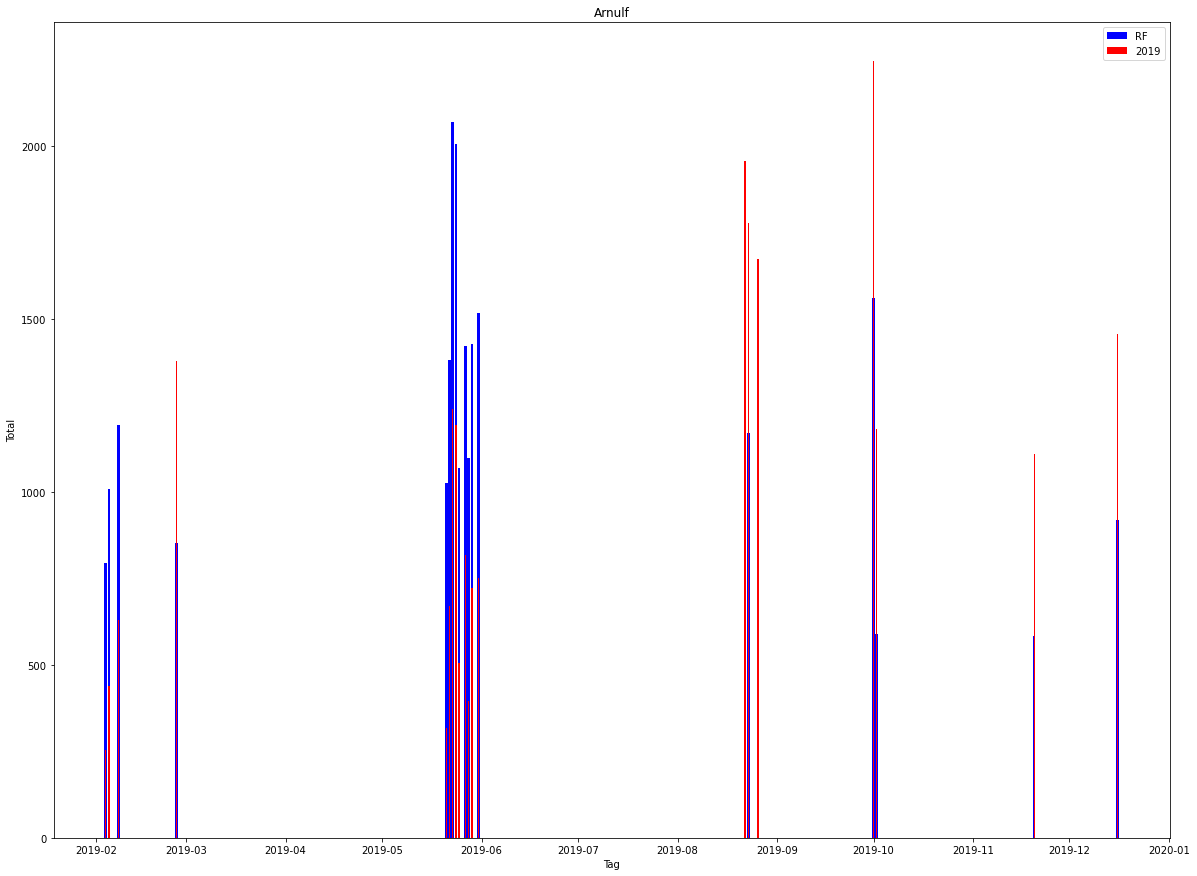

In [664]:
top_errors = df_try.sort_values(by = 'error', ascending=False)[:20]
plotResults(top_errors, top_errors)

Im Mai sind eine Woche lang gro√üe Fehler.